## 将第一节课实践的DCGAN代码改成lsgan的损失函数

可以看下有提示的地方。

In [1]:
#导入一些必要的包
import os
import random
import paddle 
import paddle.nn as nn
import paddle.optimizer as optim
import paddle.vision.datasets as dset
import paddle.vision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/rcsetup.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, Mapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:53: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sized
2021-09-11 22:55:09,244 - INFO - font search path ['/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf', '/opt/co

In [2]:
dataset = paddle.vision.datasets.MNIST(mode='train', 
                                        transform=transforms.Compose([
                                        # resize ->(32,32)
                                        transforms.Resize((32,32)),
                                        # 归一化到-1~1
                                        transforms.Normalize([127.5], [127.5])
                                    ]))

dataloader = paddle.io.DataLoader(dataset, batch_size=32,
                                  shuffle=True, num_workers=4)

Cache file /home/aistudio/.cache/paddle/dataset/mnist/train-images-idx3-ubyte.gz not found, downloading https://dataset.bj.bcebos.com/mnist/train-images-idx3-ubyte.gz 
Begin to download

Download finished
Cache file /home/aistudio/.cache/paddle/dataset/mnist/train-labels-idx1-ubyte.gz not found, downloading https://dataset.bj.bcebos.com/mnist/train-labels-idx1-ubyte.gz 
Begin to download
........
Download finished


In [3]:
#参数初始化的模块
@paddle.no_grad()
def normal_(x, mean=0., std=1.):
    temp_value = paddle.normal(mean, std, shape=x.shape)
    x.set_value(temp_value)
    return x

@paddle.no_grad()
def uniform_(x, a=-1., b=1.):
    temp_value = paddle.uniform(min=a, max=b, shape=x.shape)
    x.set_value(temp_value)
    return x

@paddle.no_grad()
def constant_(x, value):
    temp_value = paddle.full(x.shape, value, x.dtype)
    x.set_value(temp_value)
    return x

def weights_init(m):
    classname = m.__class__.__name__
    if hasattr(m, 'weight') and classname.find('Conv') != -1:
        normal_(m.weight, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        normal_(m.weight, 1.0, 0.02)
        constant_(m.bias, 0)

In [4]:
# Generator Code
class Generator(nn.Layer):
    def __init__(self, ):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            # input is Z, [B, 100, 1, 1] -> [B, 64 * 4, 4, 4]
            nn.Conv2DTranspose(100, 64 * 4, 4, 1, 0, bias_attr=False),
            nn.BatchNorm2D(64 * 4),
            nn.ReLU(True),
            # state size. [B, 64 * 4, 4, 4] -> [B, 64 * 2, 8, 8]
            nn.Conv2DTranspose(64 * 4, 64 * 2, 4, 2, 1, bias_attr=False),
            nn.BatchNorm2D(64 * 2),
            nn.ReLU(True),
            # state size. [B, 64 * 2, 8, 8] -> [B, 64, 16, 16]
            nn.Conv2DTranspose( 64 * 2, 64, 4, 2, 1, bias_attr=False),
            nn.BatchNorm2D(64),
            nn.ReLU(True),
            # state size. [B, 64, 16, 16] -> [B, 1, 32, 32]
            nn.Conv2DTranspose( 64, 1, 4, 2, 1, bias_attr=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.gen(x)


netG = Generator()
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (gen): Sequential(
    (0): Conv2DTranspose(100, 256, kernel_size=[4, 4], data_format=NCHW)
    (1): BatchNorm2D(num_features=256, momentum=0.9, epsilon=1e-05)
    (2): ReLU(name=True)
    (3): Conv2DTranspose(256, 128, kernel_size=[4, 4], stride=[2, 2], padding=1, data_format=NCHW)
    (4): BatchNorm2D(num_features=128, momentum=0.9, epsilon=1e-05)
    (5): ReLU(name=True)
    (6): Conv2DTranspose(128, 64, kernel_size=[4, 4], stride=[2, 2], padding=1, data_format=NCHW)
    (7): BatchNorm2D(num_features=64, momentum=0.9, epsilon=1e-05)
    (8): ReLU(name=True)
    (9): Conv2DTranspose(64, 1, kernel_size=[4, 4], stride=[2, 2], padding=1, data_format=NCHW)
    (10): Tanh()
  )
)


In [5]:
class Discriminator(nn.Layer):
    def __init__(self,):
        super(Discriminator, self).__init__()
        self.dis = nn.Sequential(

            # input [B, 1, 32, 32] -> [B, 64, 16, 16]
            nn.Conv2D(1, 64, 4, 2, 1, bias_attr=False),
            nn.LeakyReLU(0.2),

            # state size. [B, 64, 16, 16] -> [B, 128, 8, 8]
            nn.Conv2D(64, 64 * 2, 4, 2, 1, bias_attr=False),
            nn.BatchNorm2D(64 * 2),
            nn.LeakyReLU(0.2),

            # state size. [B, 128, 8, 8] -> [B, 256, 4, 4]
            nn.Conv2D(64 * 2, 64 * 4, 4, 2, 1, bias_attr=False),
            nn.BatchNorm2D(64 * 4),
            nn.LeakyReLU(0.2),

            # state size. [B, 256, 4, 4] -> [B, 1, 1, 1]
            nn.Conv2D(64 * 4, 1, 4, 1, 0, bias_attr=False),
            # 这里为需要改变的地方
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.dis(x)

netD = Discriminator()
netD.apply(weights_init)
print(netD)

Discriminator(
  (dis): Sequential(
    (0): Conv2D(1, 64, kernel_size=[4, 4], stride=[2, 2], padding=1, data_format=NCHW)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2D(64, 128, kernel_size=[4, 4], stride=[2, 2], padding=1, data_format=NCHW)
    (3): BatchNorm2D(num_features=128, momentum=0.9, epsilon=1e-05)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2D(128, 256, kernel_size=[4, 4], stride=[2, 2], padding=1, data_format=NCHW)
    (6): BatchNorm2D(num_features=256, momentum=0.9, epsilon=1e-05)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2D(256, 1, kernel_size=[4, 4], data_format=NCHW)
    (9): Sigmoid()
  )
)


In [ ]:
# Initialize BCELoss function
# 这里为需要改变的地方
loss = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = paddle.randn([32, 100, 1, 1], dtype='float32')

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(parameters=netD.parameters(), learning_rate=0.0002, beta1=0.5, beta2=0.999)
optimizerG = optim.Adam(parameters=netG.parameters(), learning_rate=0.0002, beta1=0.5, beta2=0.999)


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/norm.py:648: UserWarning: When training, we now always track global mean and variance.
  "When training, we now always track global mean and variance.")
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated 

Epoch ID=0 Batch ID=0 

 D-Loss=1.6130207777023315 G-Loss=0.4536616802215576


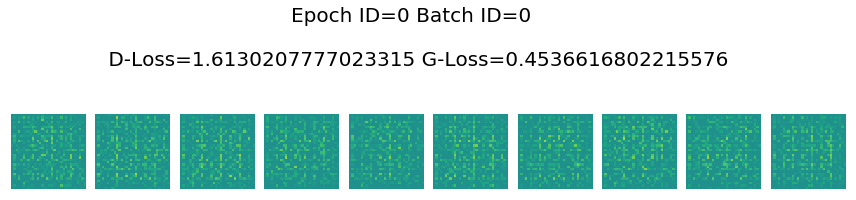

Epoch ID=0 Batch ID=100 

 D-Loss=0.19651514291763306 G-Loss=2.0658774375915527


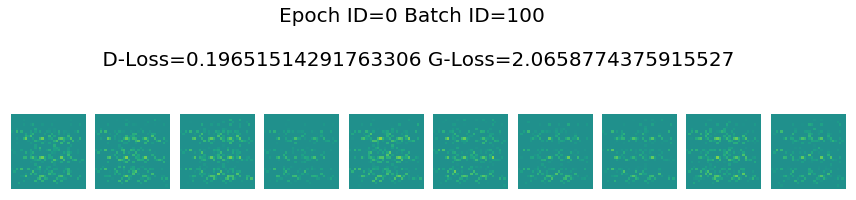

Epoch ID=0 Batch ID=200 

 D-Loss=0.1600644886493683 G-Loss=1.5777108669281006


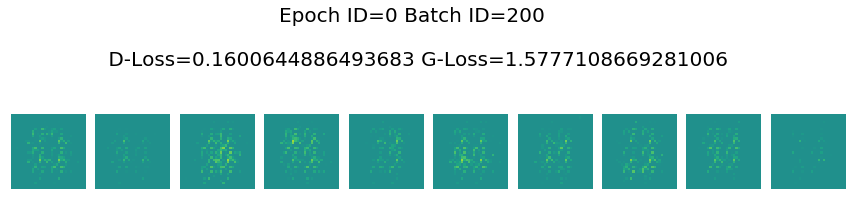

Epoch ID=0 Batch ID=300 

 D-Loss=0.274976909160614 G-Loss=2.0914440155029297


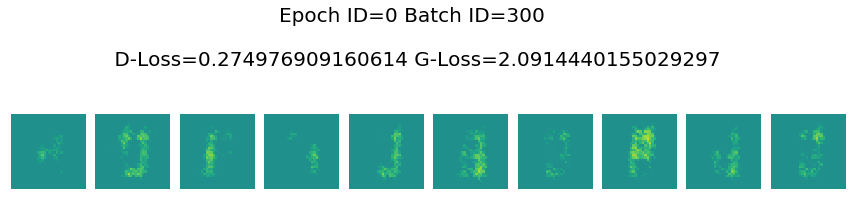

Epoch ID=0 Batch ID=400 

 D-Loss=0.18803036212921143 G-Loss=0.9436270594596863


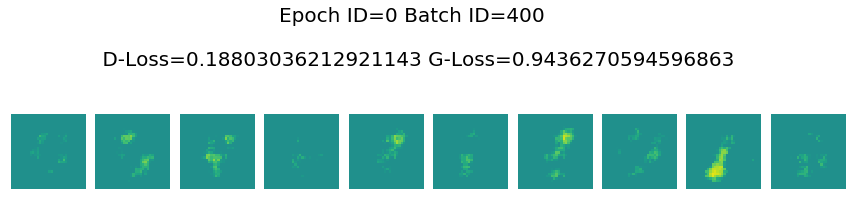

Epoch ID=0 Batch ID=500 

 D-Loss=0.11322193592786789 G-Loss=0.7968080043792725


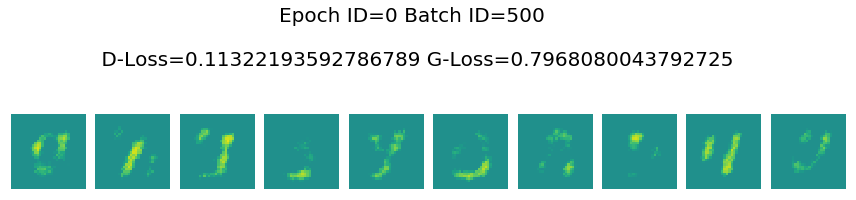

Epoch ID=0 Batch ID=600 

 D-Loss=0.07935180515050888 G-Loss=1.1510111093521118


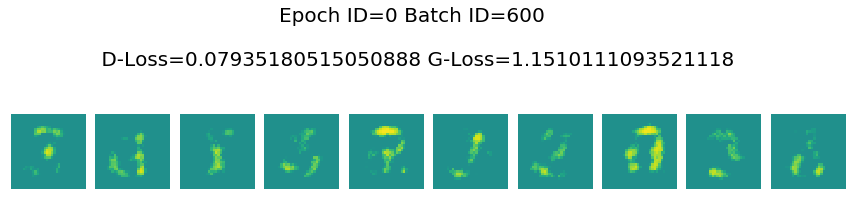

Epoch ID=0 Batch ID=700 

 D-Loss=0.42893898487091064 G-Loss=0.3720996379852295


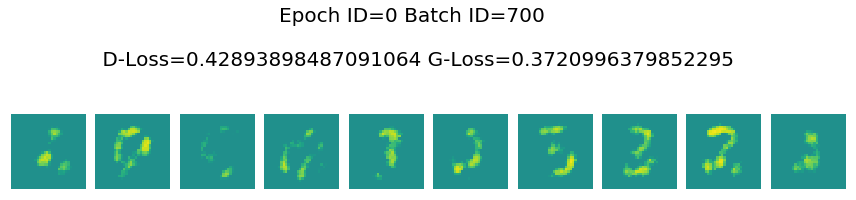

Epoch ID=0 Batch ID=800 

 D-Loss=0.16958799958229065 G-Loss=0.5034866333007812


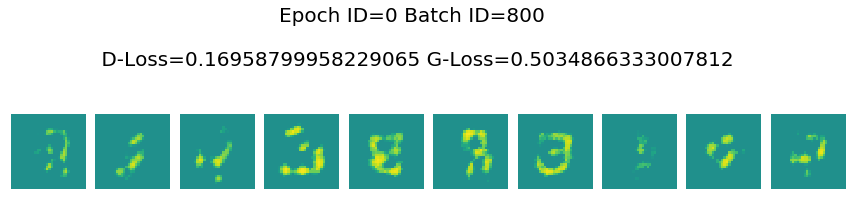

Epoch ID=0 Batch ID=900 

 D-Loss=0.09833846986293793 G-Loss=0.5463386178016663


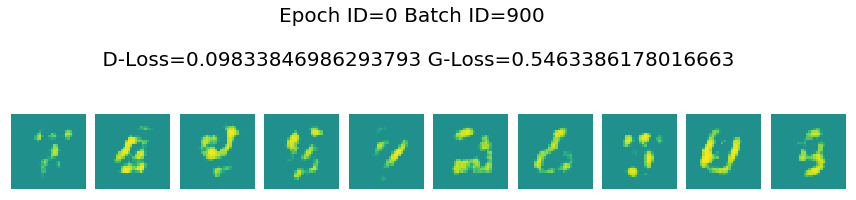

Epoch ID=0 Batch ID=1000 

 D-Loss=0.0938296765089035 G-Loss=0.6803607940673828


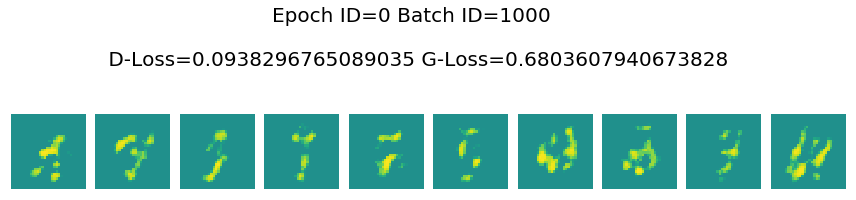

Epoch ID=0 Batch ID=1100 

 D-Loss=0.056475333869457245 G-Loss=1.2449395656585693


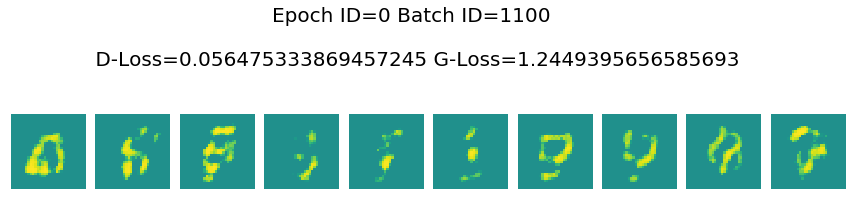

Epoch ID=0 Batch ID=1200 

 D-Loss=0.058132655918598175 G-Loss=0.762130856513977


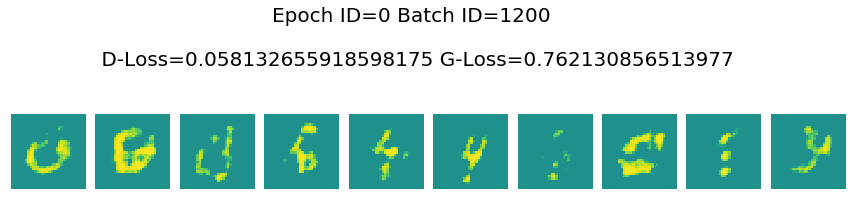

Epoch ID=0 Batch ID=1300 

 D-Loss=0.1841270625591278 G-Loss=1.413691759109497


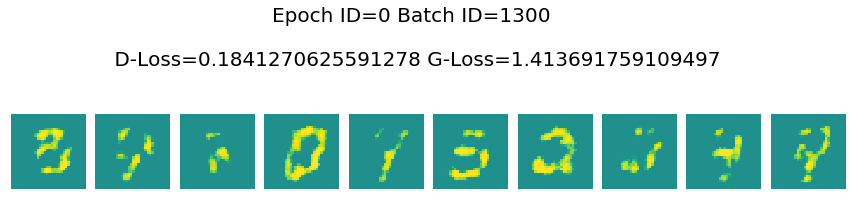

Epoch ID=0 Batch ID=1400 

 D-Loss=0.053129710257053375 G-Loss=1.3446482419967651


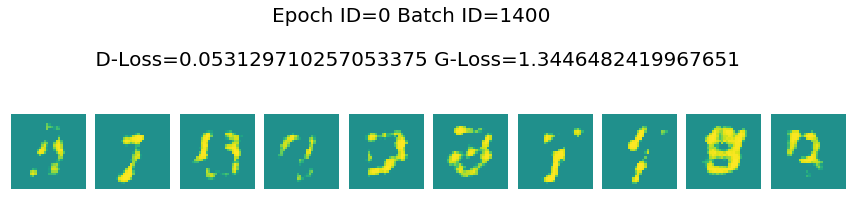

Epoch ID=0 Batch ID=1500 

 D-Loss=0.08864355087280273 G-Loss=1.0244442224502563


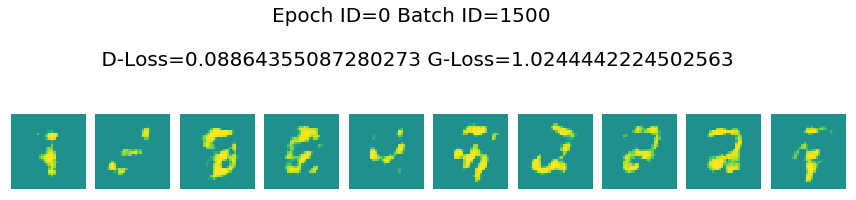

Epoch ID=0 Batch ID=1600 

 D-Loss=0.06522006541490555 G-Loss=0.8746808767318726


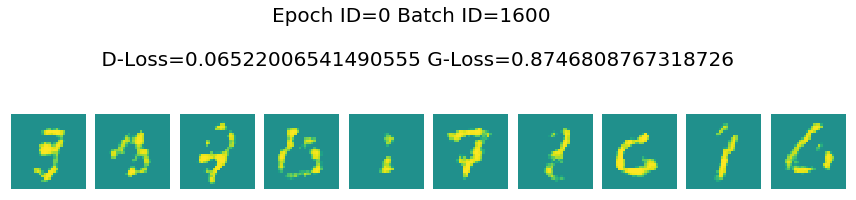

Epoch ID=0 Batch ID=1700 

 D-Loss=0.06269000470638275 G-Loss=0.8261702060699463


Epoch ID=0 Batch ID=1800 

 D-Loss=0.08431015908718109 G-Loss=0.8884986639022827


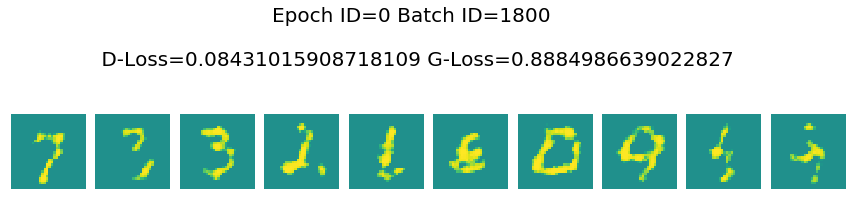

Epoch ID=1 Batch ID=0 

 D-Loss=0.1811639368534088 G-Loss=0.518226683139801


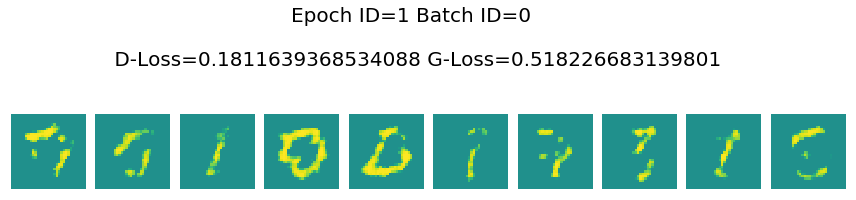

Epoch ID=1 Batch ID=100 

 D-Loss=0.07405368983745575 G-Loss=0.8342427015304565


Epoch ID=1 Batch ID=200 

 D-Loss=0.2112525850534439 G-Loss=0.5133256912231445


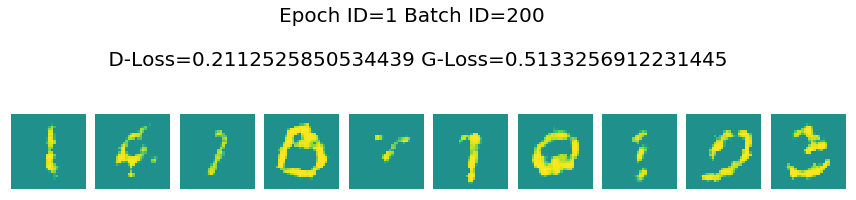

Epoch ID=1 Batch ID=300 

 D-Loss=0.20782989263534546 G-Loss=0.6551270484924316


Epoch ID=1 Batch ID=400 

 D-Loss=0.34150636196136475 G-Loss=1.0099194049835205


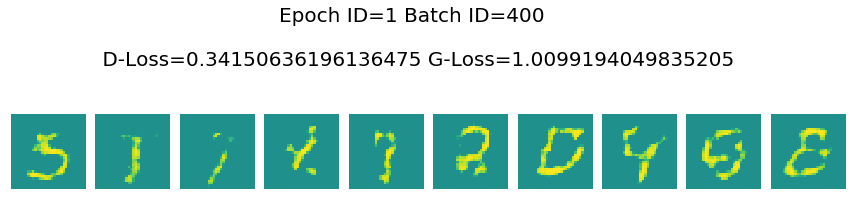

Epoch ID=1 Batch ID=500 

 D-Loss=0.3889765441417694 G-Loss=1.0727543830871582


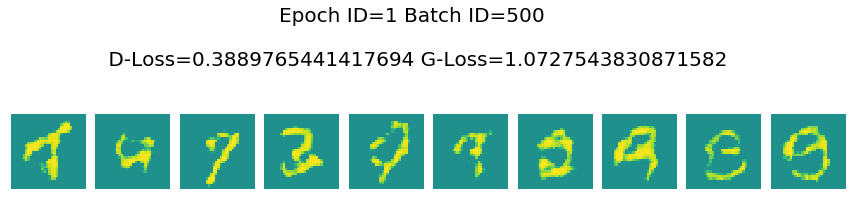

Epoch ID=1 Batch ID=600 

 D-Loss=0.15938614308834076 G-Loss=0.9613644480705261


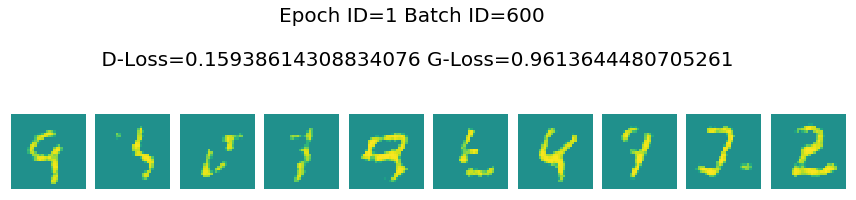

Epoch ID=1 Batch ID=700 

 D-Loss=0.24711328744888306 G-Loss=0.6541043519973755


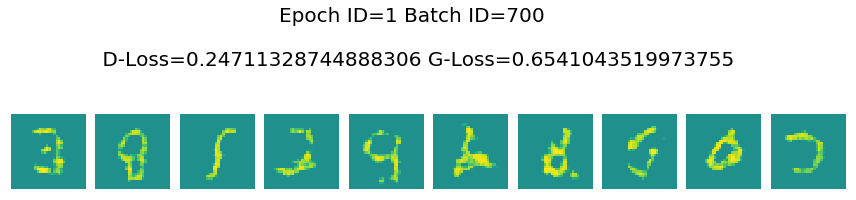

Epoch ID=1 Batch ID=800 

 D-Loss=0.1994594931602478 G-Loss=0.8411266803741455


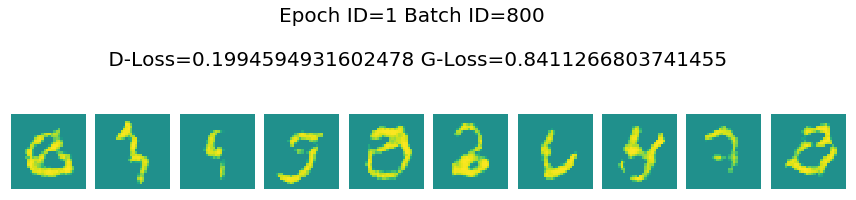

Epoch ID=1 Batch ID=900 

 D-Loss=0.14852675795555115 G-Loss=0.9950249195098877


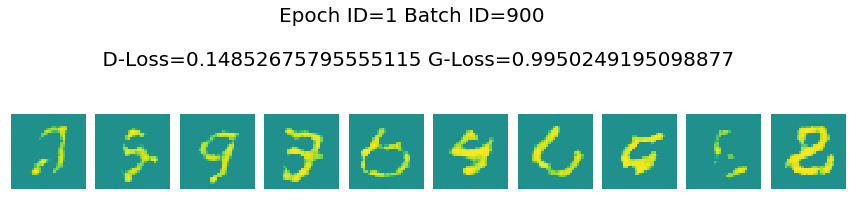

Epoch ID=1 Batch ID=1000 

 D-Loss=0.17723414301872253 G-Loss=0.7960752248764038


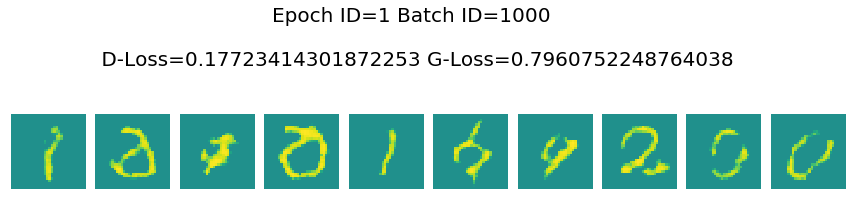

Epoch ID=1 Batch ID=1100 

 D-Loss=0.10014276206493378 G-Loss=0.831264317035675


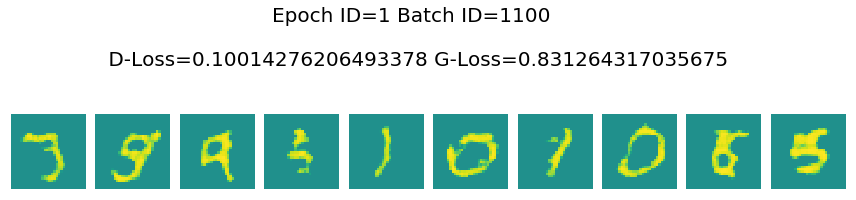

Epoch ID=1 Batch ID=1200 

 D-Loss=0.2134741246700287 G-Loss=0.494629830121994


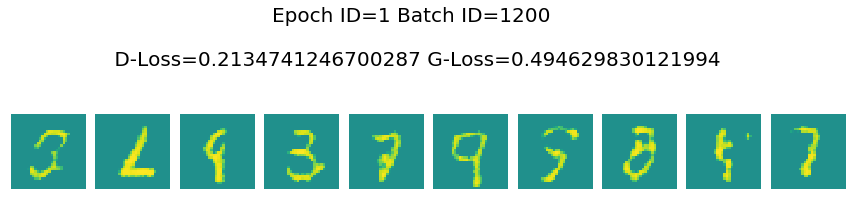

Epoch ID=1 Batch ID=1300 

 D-Loss=0.22833490371704102 G-Loss=0.811263918876648


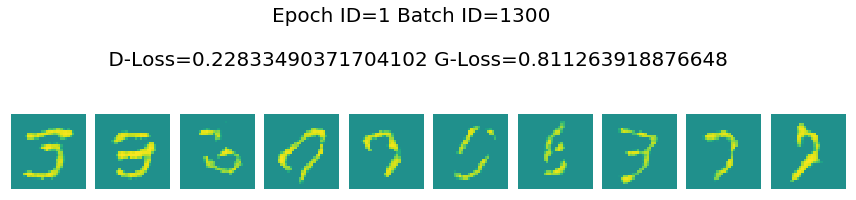

Epoch ID=1 Batch ID=1400 

 D-Loss=0.13258521258831024 G-Loss=0.4802006781101227


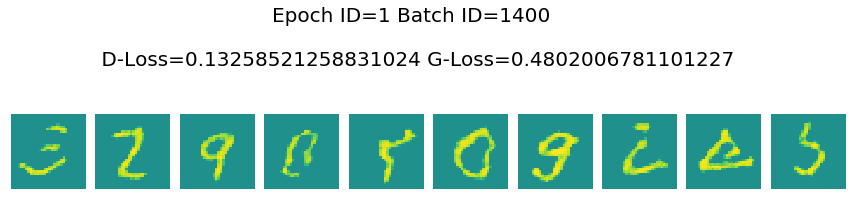

Epoch ID=1 Batch ID=1500 

 D-Loss=0.13275662064552307 G-Loss=0.47676146030426025


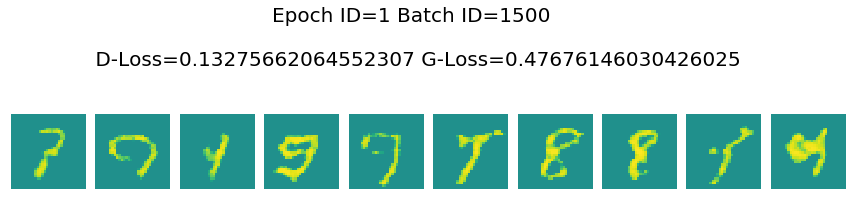

Epoch ID=1 Batch ID=1600 

 D-Loss=0.14970839023590088 G-Loss=0.8195341229438782


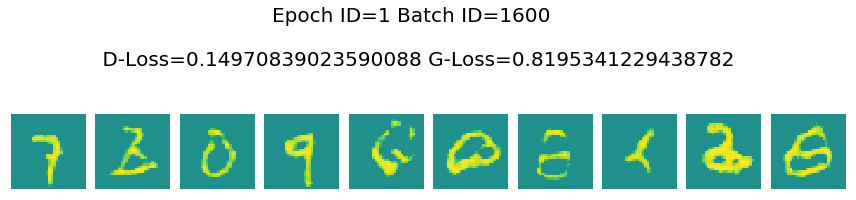

Epoch ID=1 Batch ID=1700 

 D-Loss=0.550666868686676 G-Loss=1.2405288219451904


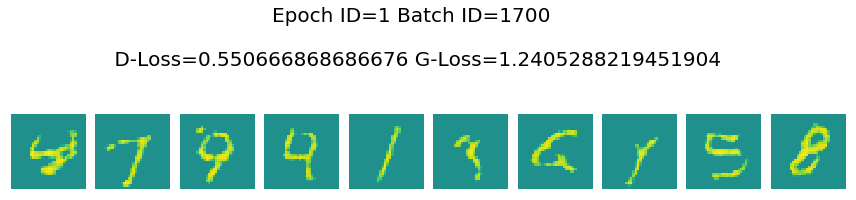

Epoch ID=1 Batch ID=1800 

 D-Loss=0.12017198652029037 G-Loss=0.46638038754463196


Epoch ID=2 Batch ID=0 

 D-Loss=0.12092159688472748 G-Loss=0.7143697738647461


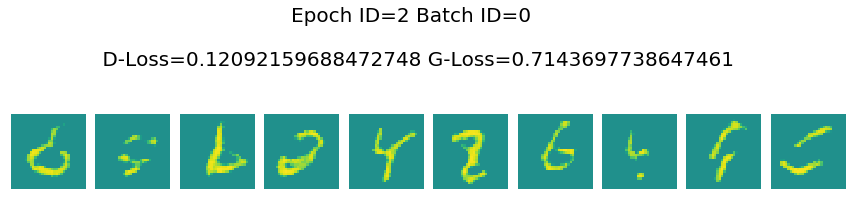

Epoch ID=2 Batch ID=100 

 D-Loss=0.09303462505340576 G-Loss=0.8485180139541626


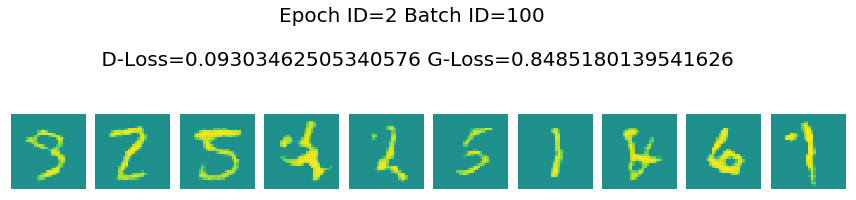

Epoch ID=2 Batch ID=200 

 D-Loss=0.22743283212184906 G-Loss=0.34183067083358765


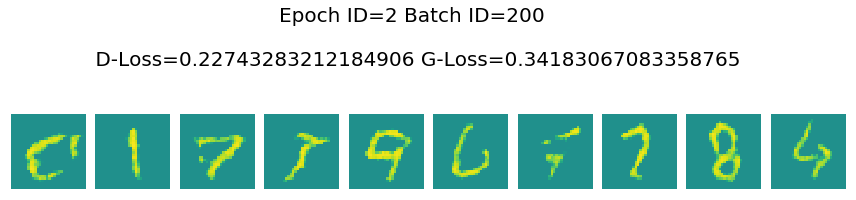

Epoch ID=2 Batch ID=300 

 D-Loss=0.1184302419424057 G-Loss=1.2750601768493652


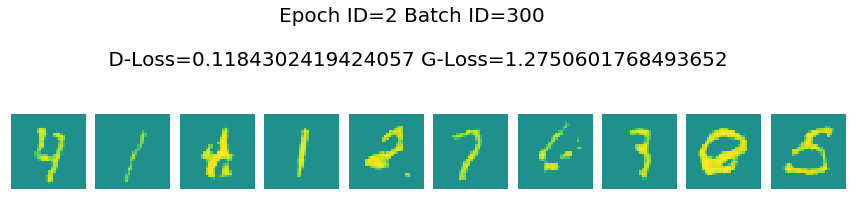

Epoch ID=2 Batch ID=400 

 D-Loss=0.17192216217517853 G-Loss=0.7424573302268982


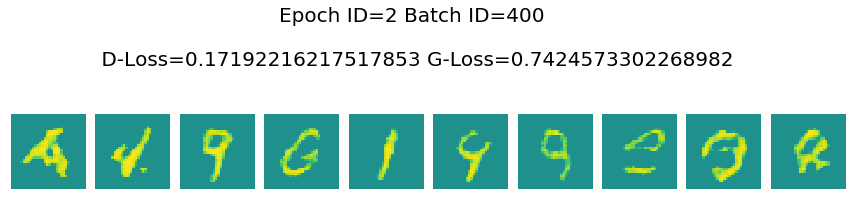

Epoch ID=2 Batch ID=500 

 D-Loss=0.3443983495235443 G-Loss=0.3539723753929138


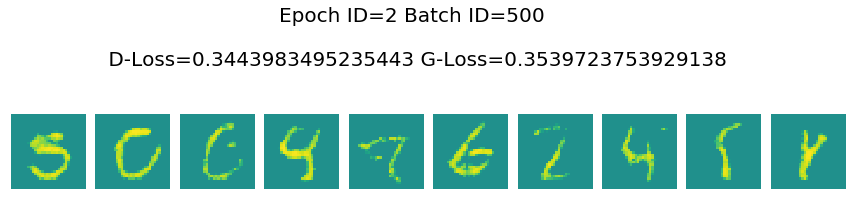

Epoch ID=2 Batch ID=600 

 D-Loss=0.1737600862979889 G-Loss=0.3667396903038025


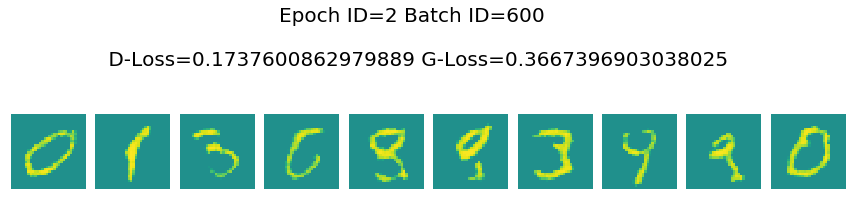

Epoch ID=2 Batch ID=700 

 D-Loss=0.3325113356113434 G-Loss=1.6082243919372559


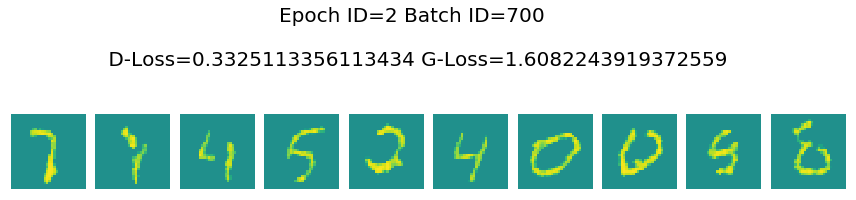

Epoch ID=2 Batch ID=800 

 D-Loss=0.2190866768360138 G-Loss=0.44111204147338867


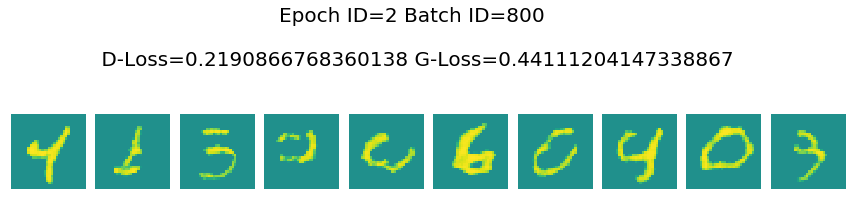

Epoch ID=2 Batch ID=900 

 D-Loss=1.0229648351669312 G-Loss=0.08315589278936386


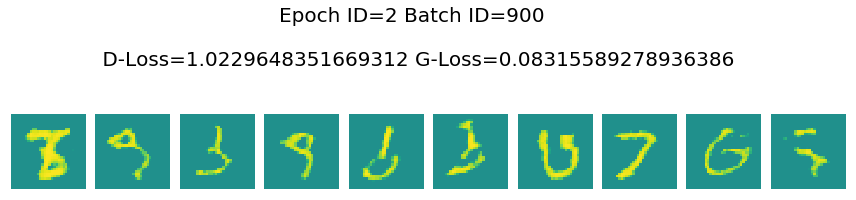

Epoch ID=2 Batch ID=1000 

 D-Loss=0.15898551046848297 G-Loss=0.7910444736480713


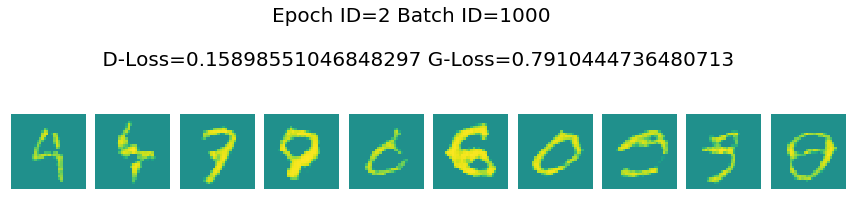

Epoch ID=2 Batch ID=1100 

 D-Loss=0.09777317941188812 G-Loss=0.535630464553833


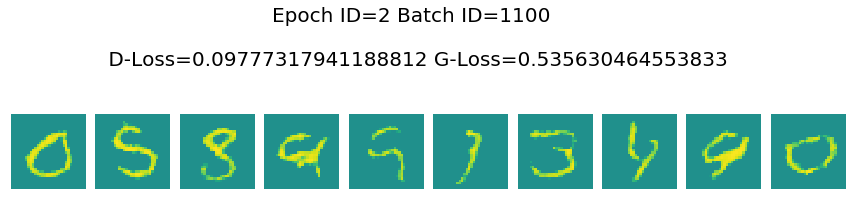

Epoch ID=2 Batch ID=1200 

 D-Loss=0.19581907987594604 G-Loss=0.45350396633148193


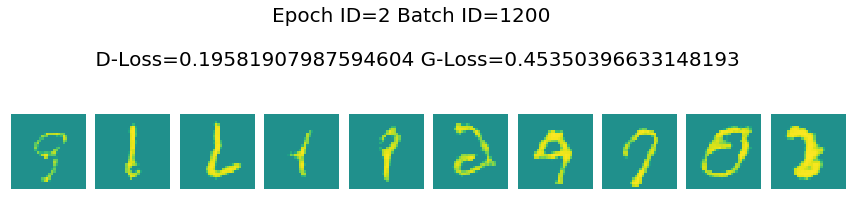

Epoch ID=2 Batch ID=1300 

 D-Loss=0.141148641705513 G-Loss=0.7645591497421265


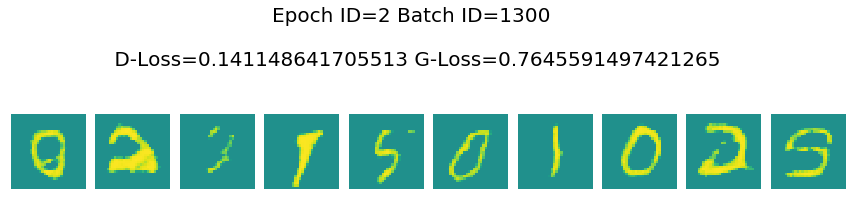

Epoch ID=2 Batch ID=1400 

 D-Loss=0.19298747181892395 G-Loss=0.8668186068534851


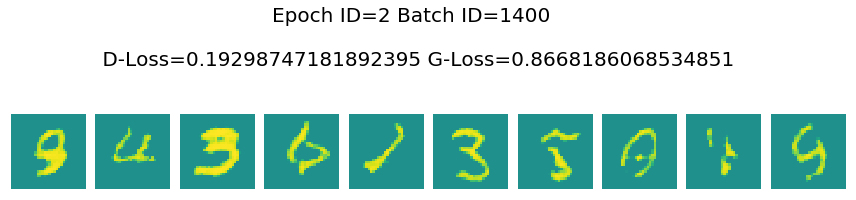

Epoch ID=2 Batch ID=1500 

 D-Loss=0.0864216536283493 G-Loss=0.789409875869751


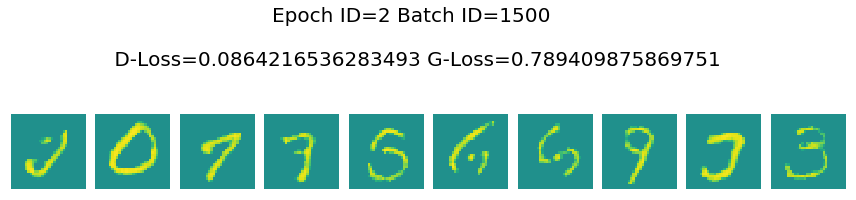

Epoch ID=2 Batch ID=1600 

 D-Loss=0.2120070457458496 G-Loss=0.8819149732589722


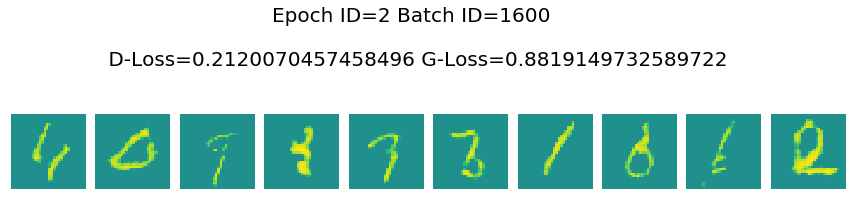

Epoch ID=2 Batch ID=1700 

 D-Loss=0.10317140817642212 G-Loss=0.8961796760559082


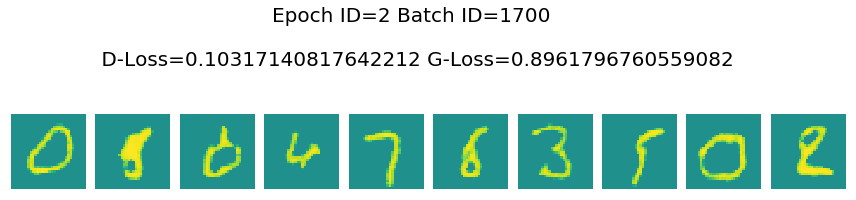

Epoch ID=2 Batch ID=1800 

 D-Loss=0.09108473360538483 G-Loss=0.6709800958633423


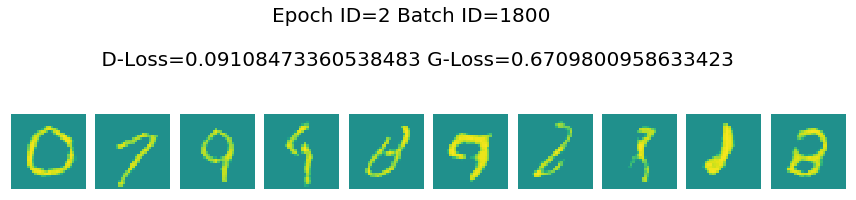

Epoch ID=3 Batch ID=0 

 D-Loss=0.08540010452270508 G-Loss=0.8315820693969727


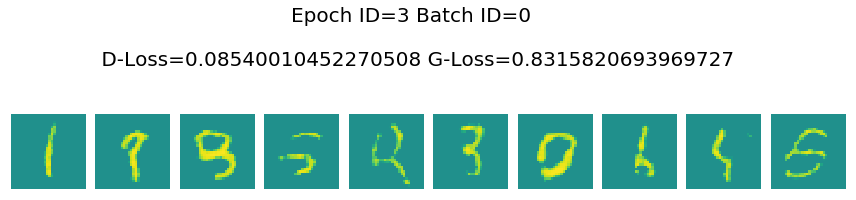

Epoch ID=3 Batch ID=100 

 D-Loss=0.22552533447742462 G-Loss=0.8955476880073547


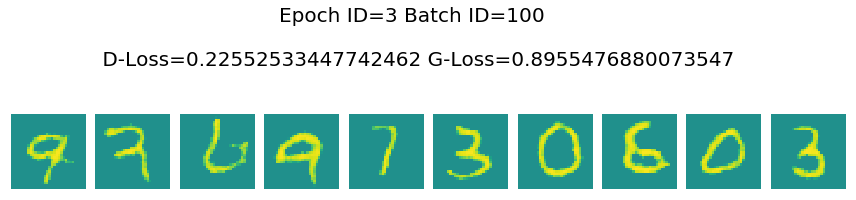

Epoch ID=3 Batch ID=200 

 D-Loss=0.12833082675933838 G-Loss=0.8502634763717651


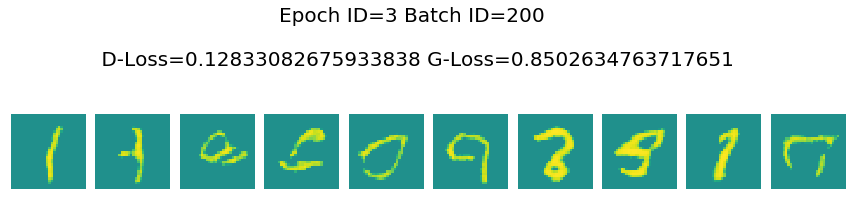

Epoch ID=3 Batch ID=300 

 D-Loss=0.10852353274822235 G-Loss=0.7802562713623047


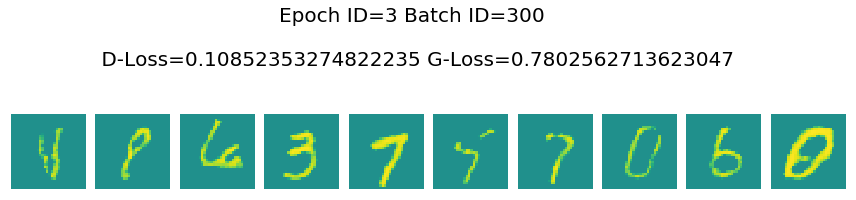

Epoch ID=3 Batch ID=400 

 D-Loss=0.16792699694633484 G-Loss=0.5977565050125122


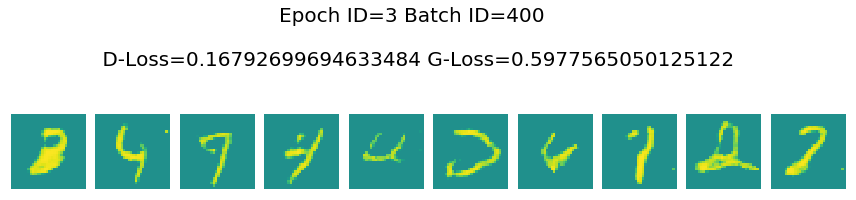

Epoch ID=3 Batch ID=500 

 D-Loss=0.12878400087356567 G-Loss=0.5889981985092163


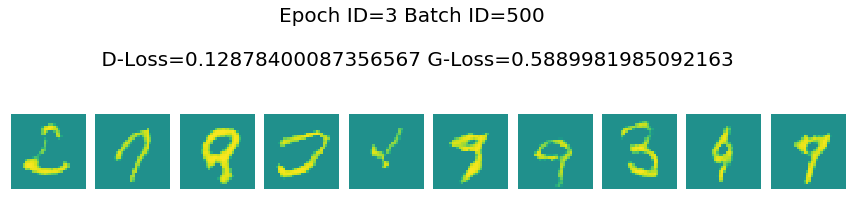

Epoch ID=3 Batch ID=600 

 D-Loss=0.08623906970024109 G-Loss=0.3888288140296936


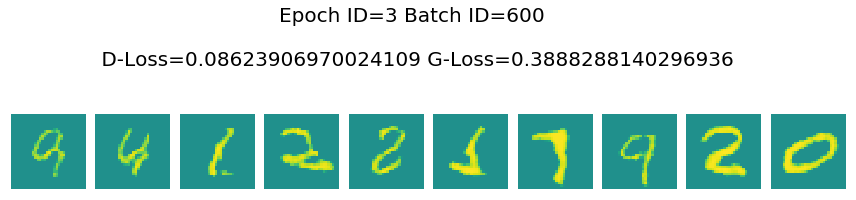

Epoch ID=3 Batch ID=700 

 D-Loss=0.17613112926483154 G-Loss=1.2421902418136597


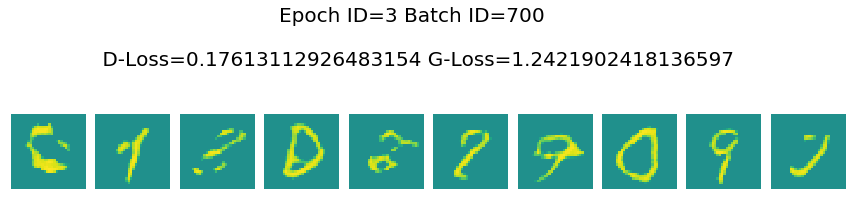

Epoch ID=3 Batch ID=800 

 D-Loss=0.0665062963962555 G-Loss=1.0502700805664062


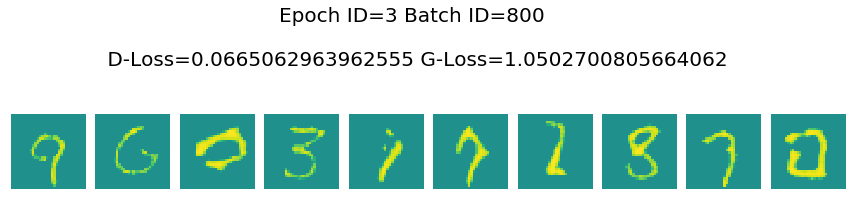

Epoch ID=3 Batch ID=900 

 D-Loss=0.186135396361351 G-Loss=0.6478708982467651


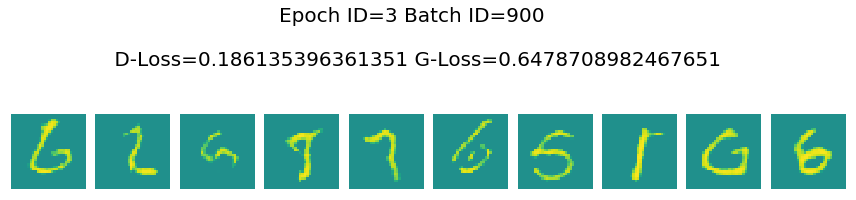

Epoch ID=3 Batch ID=1000 

 D-Loss=0.09480801969766617 G-Loss=0.5617519617080688


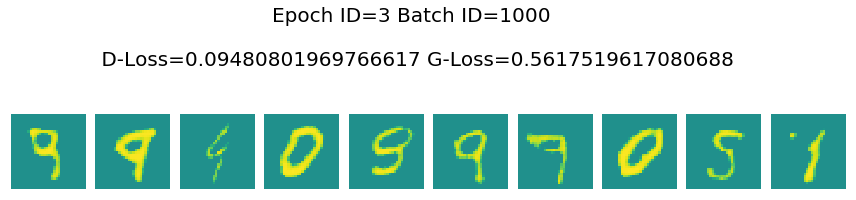

Epoch ID=3 Batch ID=1100 

 D-Loss=0.2230483591556549 G-Loss=0.4269752502441406


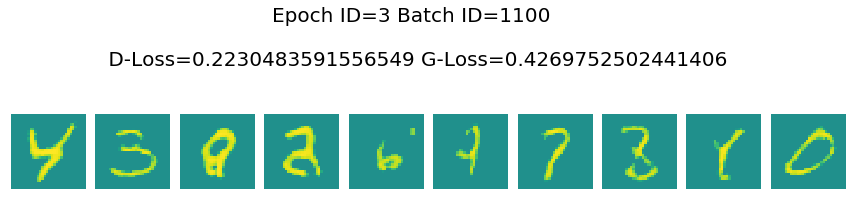

Epoch ID=3 Batch ID=1200 

 D-Loss=0.5282200574874878 G-Loss=0.3931974768638611


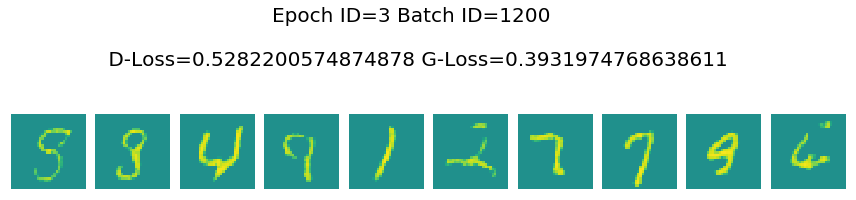

Epoch ID=3 Batch ID=1300 

 D-Loss=0.06549694389104843 G-Loss=0.737123429775238


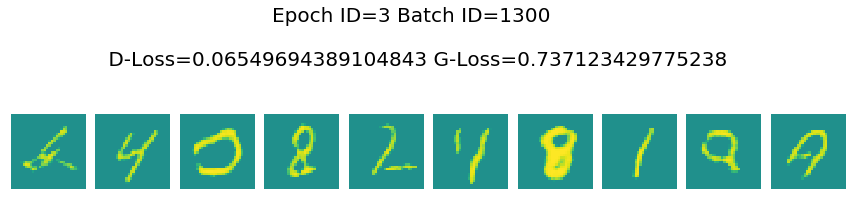

Epoch ID=3 Batch ID=1400 

 D-Loss=0.0891399085521698 G-Loss=0.9010097980499268


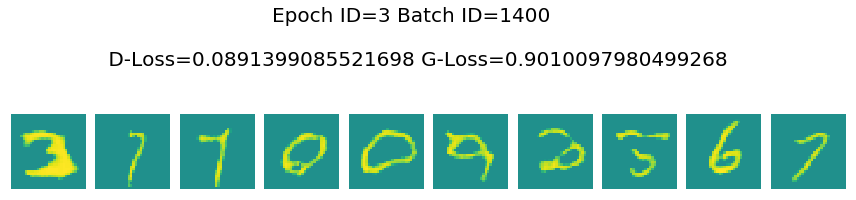

Epoch ID=3 Batch ID=1500 

 D-Loss=0.05171328783035278 G-Loss=0.7427089214324951


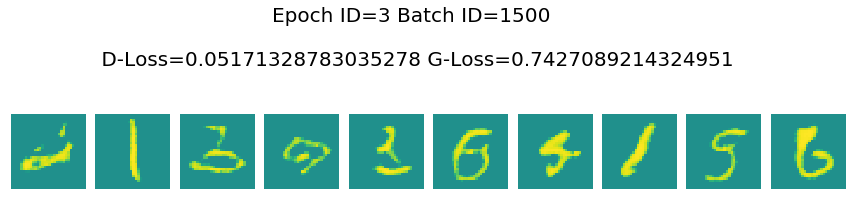

Epoch ID=3 Batch ID=1600 

 D-Loss=0.09029670059680939 G-Loss=1.3892269134521484


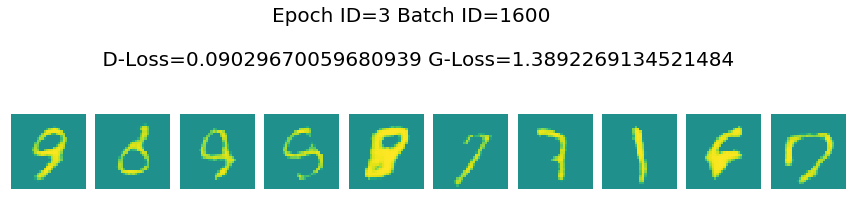

Epoch ID=3 Batch ID=1700 

 D-Loss=0.03931786119937897 G-Loss=0.8586122989654541


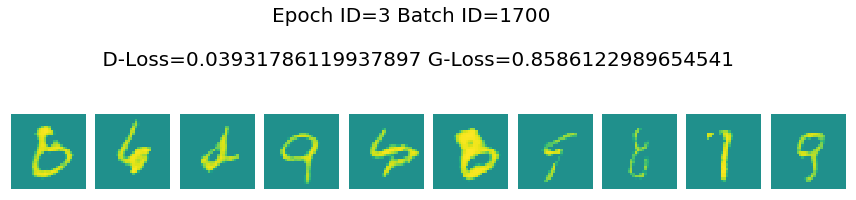

Epoch ID=3 Batch ID=1800 

 D-Loss=0.04944867640733719 G-Loss=0.884692370891571


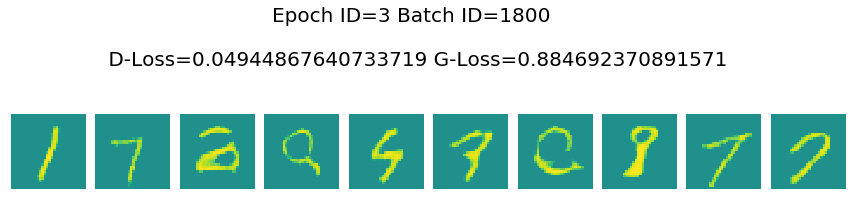

Epoch ID=4 Batch ID=0 

 D-Loss=0.2291625738143921 G-Loss=0.5835493803024292


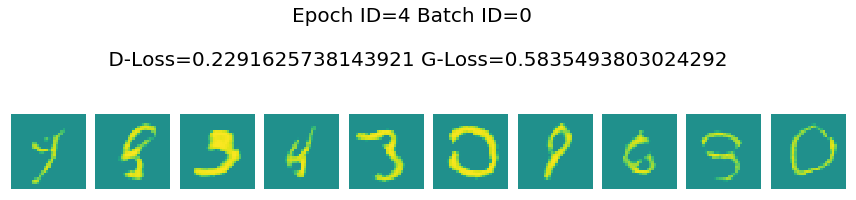

Epoch ID=4 Batch ID=100 

 D-Loss=0.0586804561316967 G-Loss=1.0130510330200195


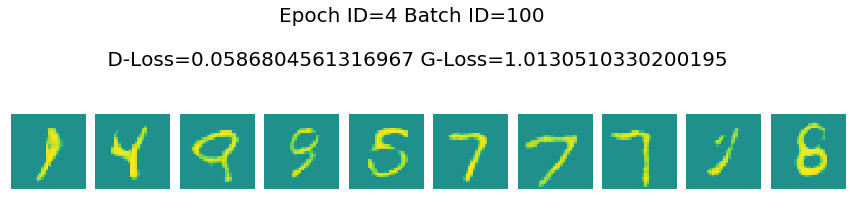

Epoch ID=4 Batch ID=200 

 D-Loss=0.08272688835859299 G-Loss=0.8240166902542114


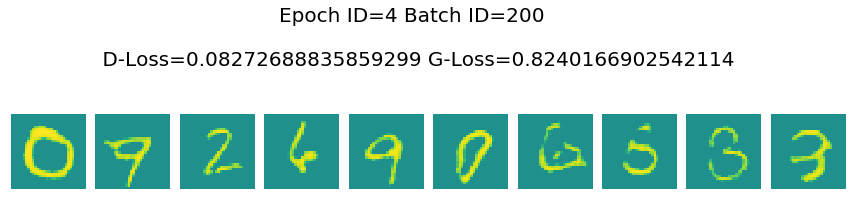

Epoch ID=4 Batch ID=300 

 D-Loss=0.09232720732688904 G-Loss=0.9964656829833984


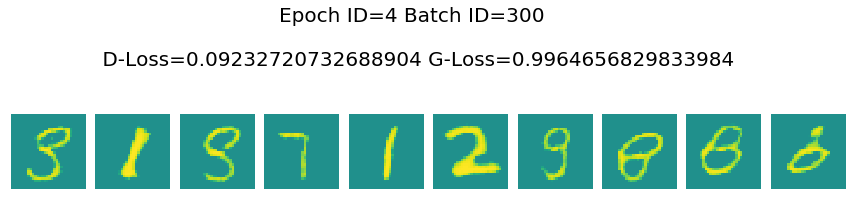

Epoch ID=4 Batch ID=400 

 D-Loss=0.03177856653928757 G-Loss=0.723981499671936


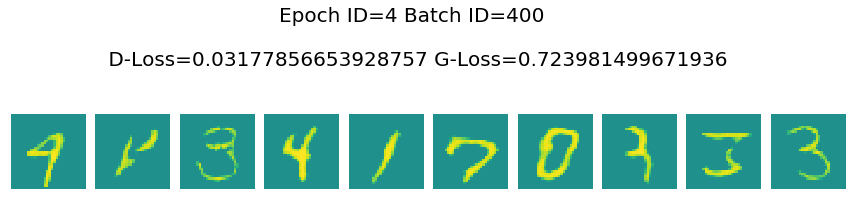

Epoch ID=4 Batch ID=500 

 D-Loss=0.07838955521583557 G-Loss=0.6764752268791199


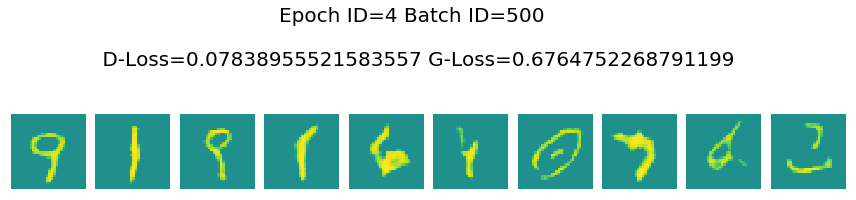

Epoch ID=4 Batch ID=600 

 D-Loss=0.02270299568772316 G-Loss=0.7943677306175232


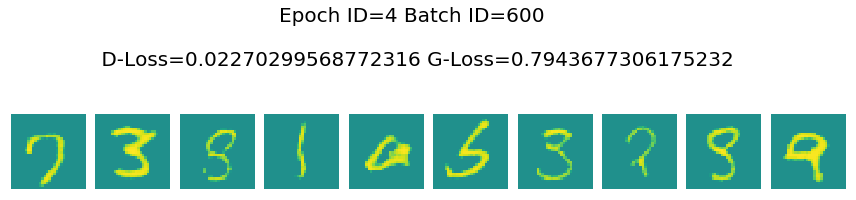

Epoch ID=4 Batch ID=700 

 D-Loss=0.055199578404426575 G-Loss=0.8204815983772278


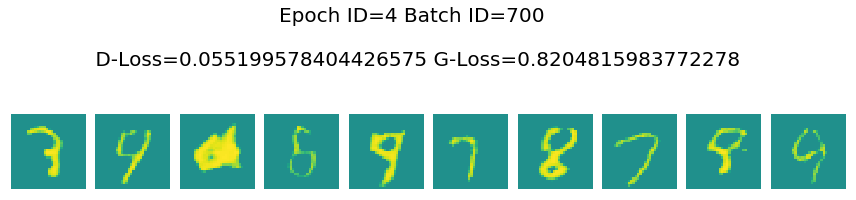

Epoch ID=4 Batch ID=800 

 D-Loss=0.1451006829738617 G-Loss=1.0552082061767578


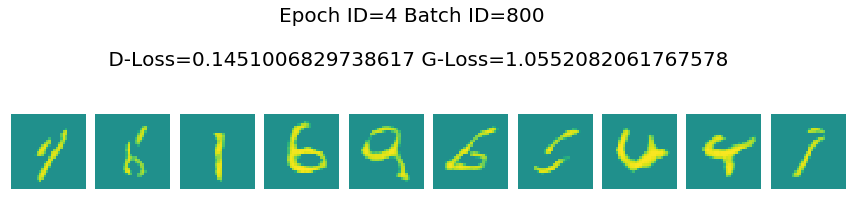

Epoch ID=4 Batch ID=900 

 D-Loss=0.10489720106124878 G-Loss=0.6329088807106018


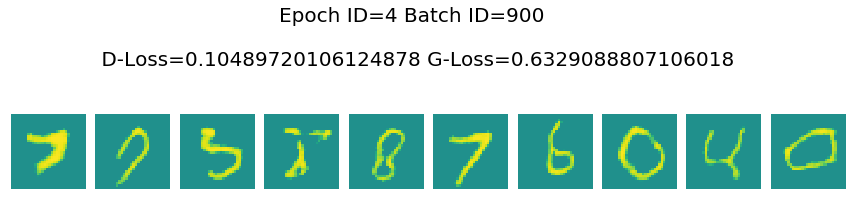

Epoch ID=4 Batch ID=1000 

 D-Loss=0.8095537424087524 G-Loss=0.4368317723274231


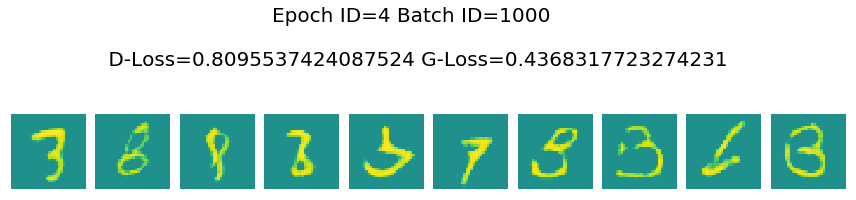

Epoch ID=4 Batch ID=1100 

 D-Loss=0.06617683172225952 G-Loss=0.7519437670707703


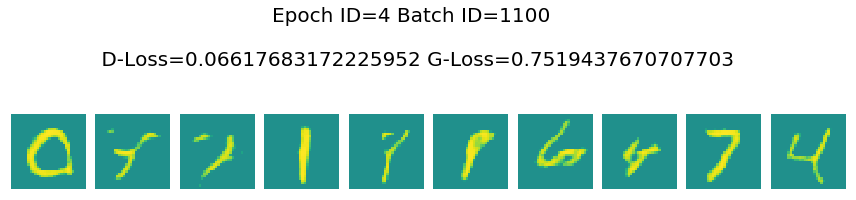

Epoch ID=4 Batch ID=1200 

 D-Loss=0.033247120678424835 G-Loss=1.2087740898132324


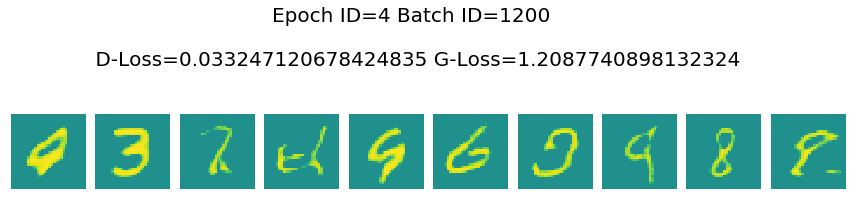

Epoch ID=4 Batch ID=1300 

 D-Loss=0.02637362852692604 G-Loss=0.9704040884971619


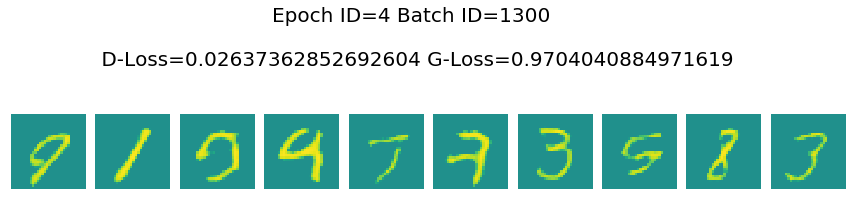

Epoch ID=4 Batch ID=1400 

 D-Loss=0.2579386830329895 G-Loss=1.7790067195892334


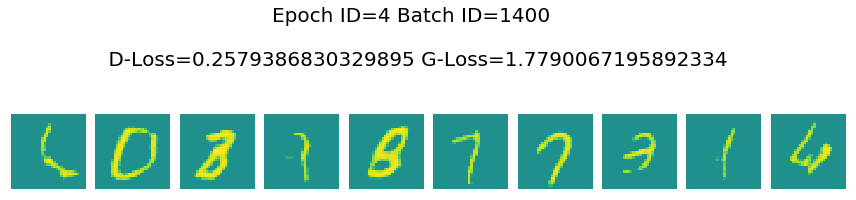

Epoch ID=4 Batch ID=1500 

 D-Loss=0.9979021549224854 G-Loss=0.037169747054576874


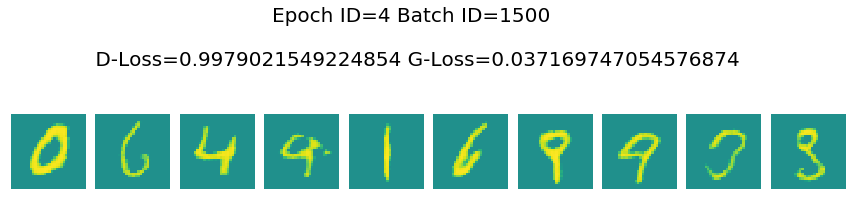

Epoch ID=4 Batch ID=1600 

 D-Loss=0.22766605019569397 G-Loss=0.36764535307884216


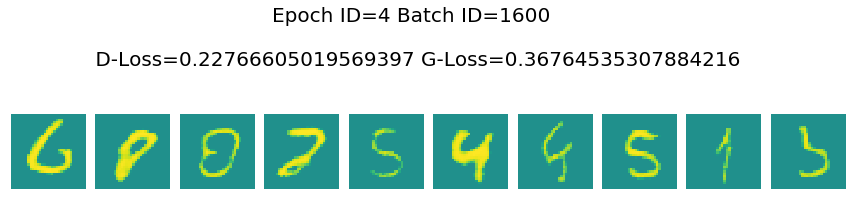

Epoch ID=4 Batch ID=1700 

 D-Loss=0.07276545464992523 G-Loss=0.7431386113166809


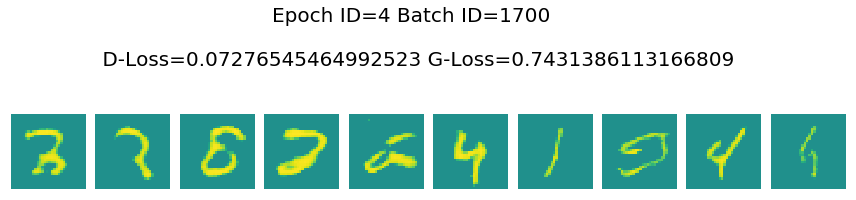

Epoch ID=4 Batch ID=1800 

 D-Loss=0.03651987388730049 G-Loss=0.992109477519989


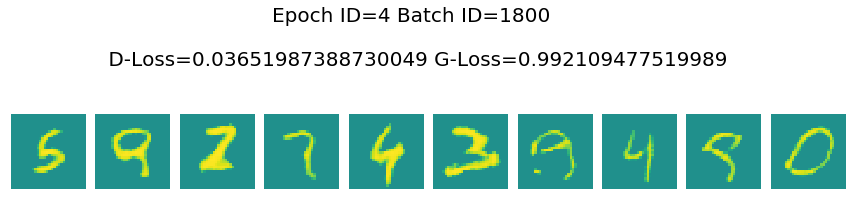

Epoch ID=5 Batch ID=0 

 D-Loss=0.03643399104475975 G-Loss=1.6898455619812012


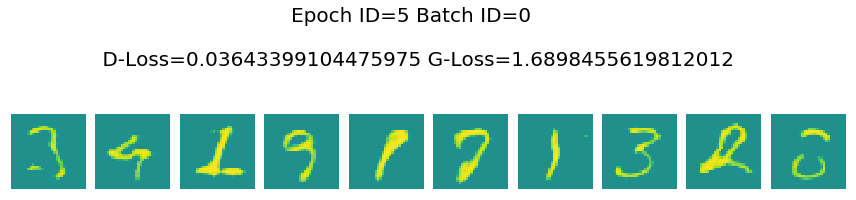

Epoch ID=5 Batch ID=100 

 D-Loss=0.017620906233787537 G-Loss=1.23893404006958


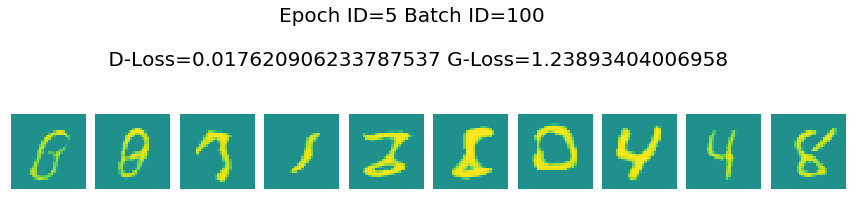

Epoch ID=5 Batch ID=200 

 D-Loss=0.1848287284374237 G-Loss=0.8117403984069824


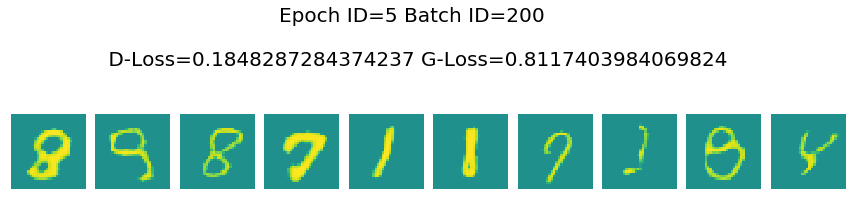

Epoch ID=5 Batch ID=300 

 D-Loss=0.0829257145524025 G-Loss=1.095192551612854


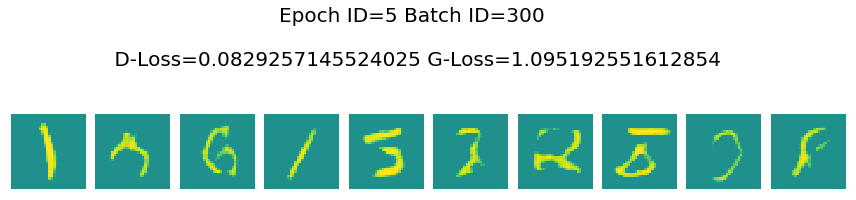

Epoch ID=5 Batch ID=400 

 D-Loss=0.16415449976921082 G-Loss=1.4904025793075562


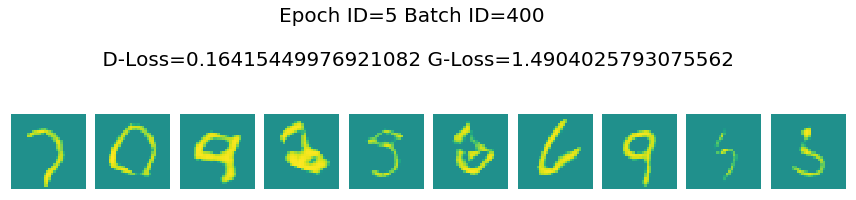

Epoch ID=5 Batch ID=500 

 D-Loss=0.04448436200618744 G-Loss=0.9836330413818359


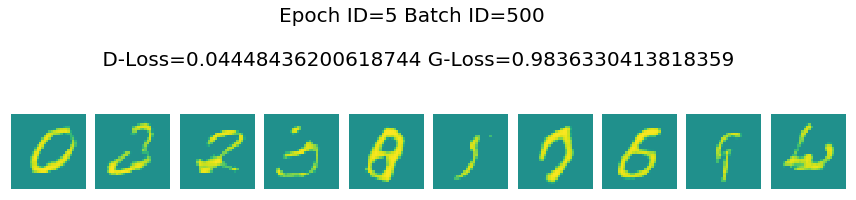

Epoch ID=5 Batch ID=600 

 D-Loss=0.2173699587583542 G-Loss=0.4409549832344055


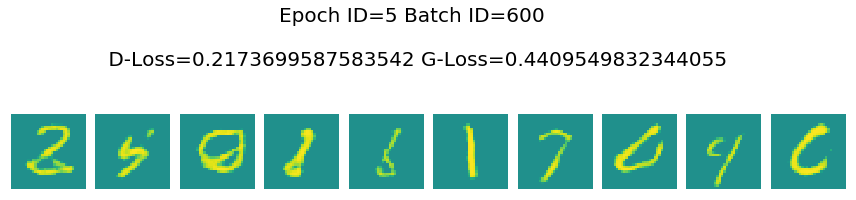

Epoch ID=5 Batch ID=700 

 D-Loss=0.037165164947509766 G-Loss=1.1431543827056885


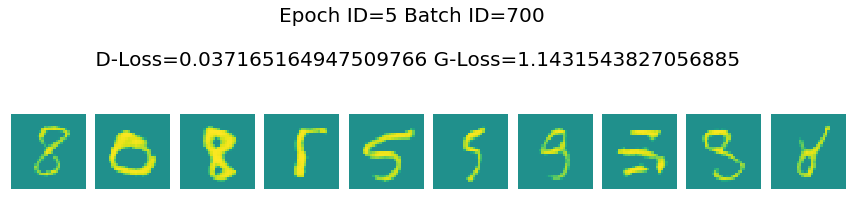

Epoch ID=5 Batch ID=800 

 D-Loss=0.40979093313217163 G-Loss=2.395095109939575


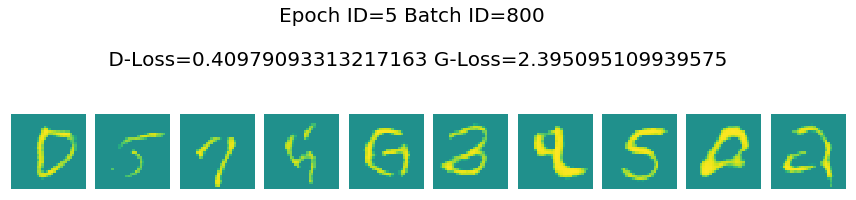

Epoch ID=5 Batch ID=900 

 D-Loss=0.13140755891799927 G-Loss=0.7609519958496094


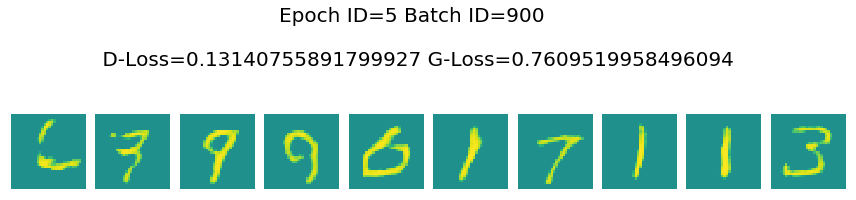

Epoch ID=5 Batch ID=1000 

 D-Loss=0.0375601127743721 G-Loss=0.968184769153595


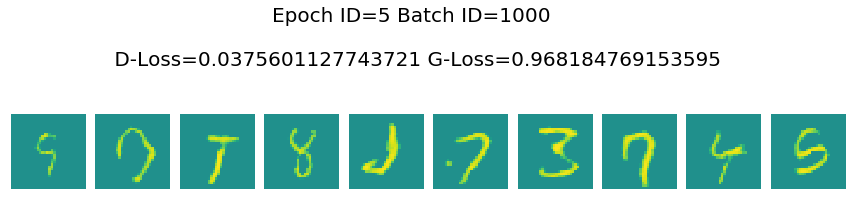

Epoch ID=5 Batch ID=1100 

 D-Loss=0.03683722764253616 G-Loss=0.8154363036155701


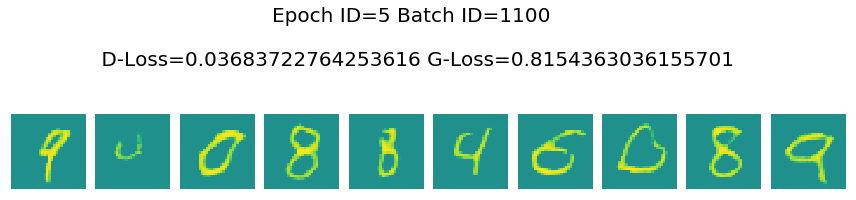

Epoch ID=5 Batch ID=1200 

 D-Loss=0.3849833905696869 G-Loss=0.7841767072677612


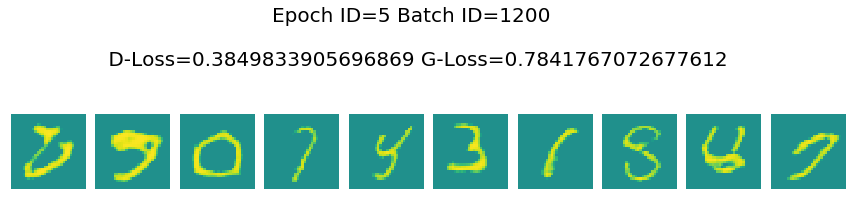

Epoch ID=5 Batch ID=1300 

 D-Loss=0.0715847909450531 G-Loss=0.5097807049751282


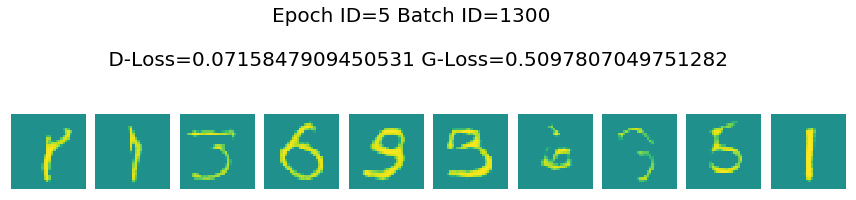

Epoch ID=5 Batch ID=1400 

 D-Loss=0.0992397591471672 G-Loss=1.2262163162231445


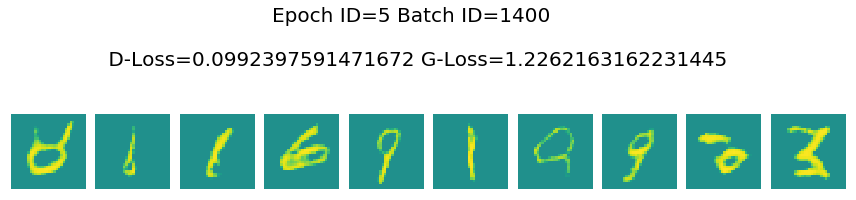

Epoch ID=5 Batch ID=1500 

 D-Loss=0.07497256249189377 G-Loss=0.669194221496582


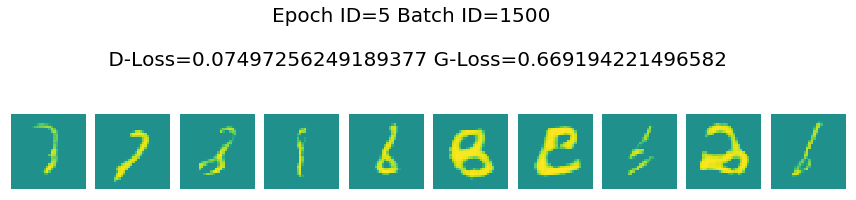

Epoch ID=5 Batch ID=1600 

 D-Loss=0.019792377948760986 G-Loss=0.6846400499343872


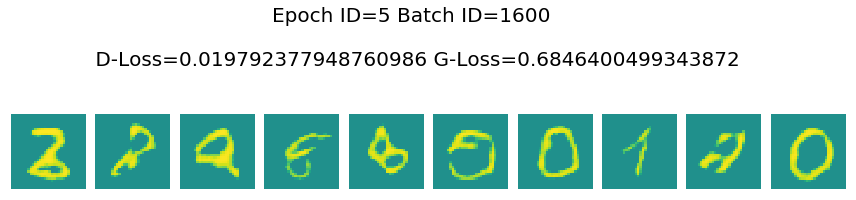

Epoch ID=5 Batch ID=1700 

 D-Loss=0.04715700447559357 G-Loss=0.5661001205444336


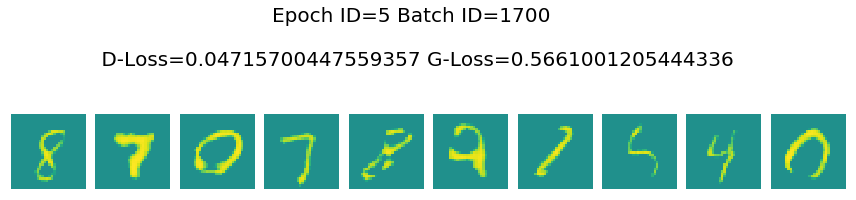

Epoch ID=5 Batch ID=1800 

 D-Loss=0.06252571195363998 G-Loss=1.0126205682754517


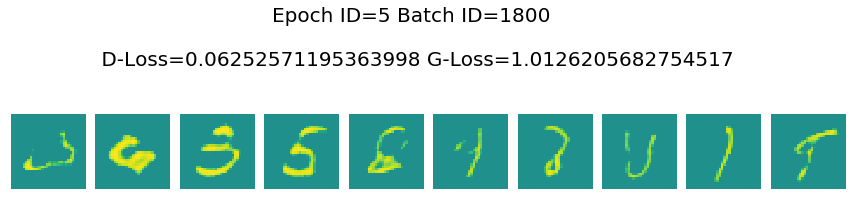

Epoch ID=6 Batch ID=0 

 D-Loss=0.03303418308496475 G-Loss=1.0666799545288086


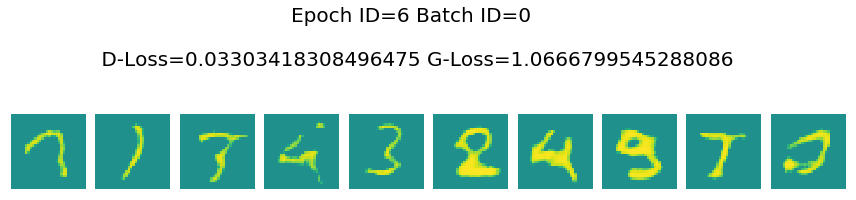

Epoch ID=6 Batch ID=100 

 D-Loss=0.014157786965370178 G-Loss=0.9545466899871826


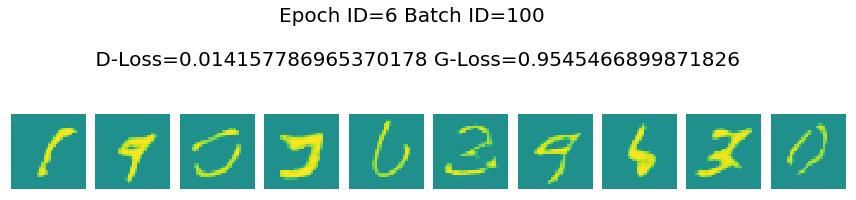

Epoch ID=6 Batch ID=200 

 D-Loss=0.02346774749457836 G-Loss=0.8003418445587158


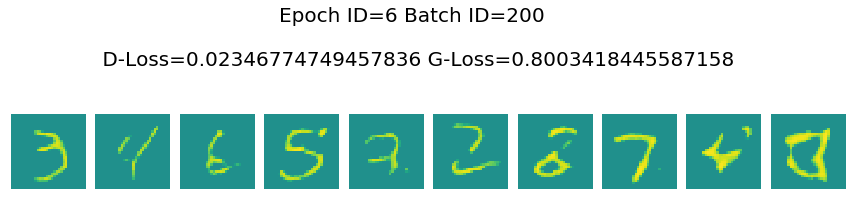

Epoch ID=6 Batch ID=300 

 D-Loss=0.026968147605657578 G-Loss=0.9856207370758057


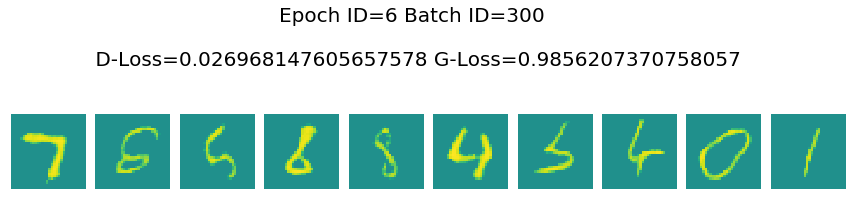

Epoch ID=6 Batch ID=400 

 D-Loss=0.07486563920974731 G-Loss=1.1184120178222656


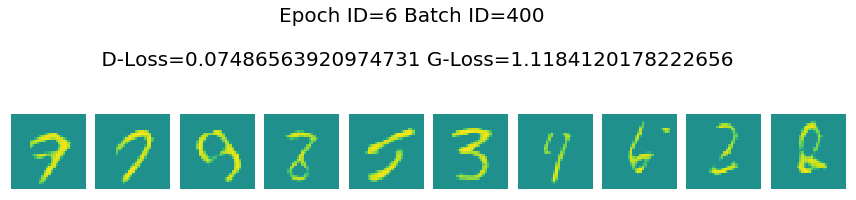

Epoch ID=6 Batch ID=500 

 D-Loss=0.04075067862868309 G-Loss=0.966684103012085


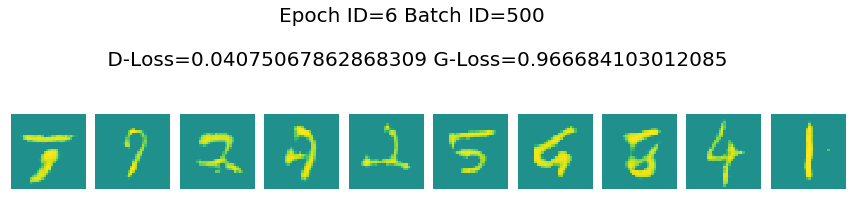

Epoch ID=6 Batch ID=600 

 D-Loss=0.035308849066495895 G-Loss=0.7381420135498047


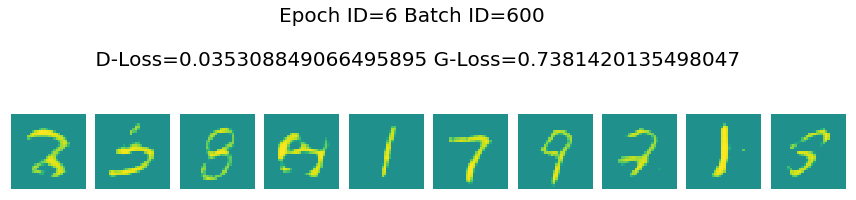

Epoch ID=6 Batch ID=700 

 D-Loss=0.04340585321187973 G-Loss=1.1938769817352295


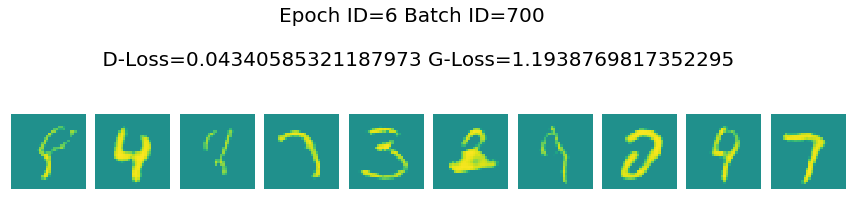

Epoch ID=6 Batch ID=800 

 D-Loss=0.03395982086658478 G-Loss=0.6996397972106934


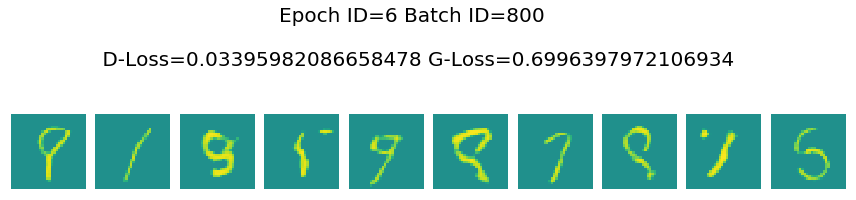

Epoch ID=6 Batch ID=900 

 D-Loss=0.25520387291908264 G-Loss=0.2778804898262024
Epoch ID=6 Batch ID=1100 

 D-Loss=0.020653914660215378 G-Loss=0.7070172429084778


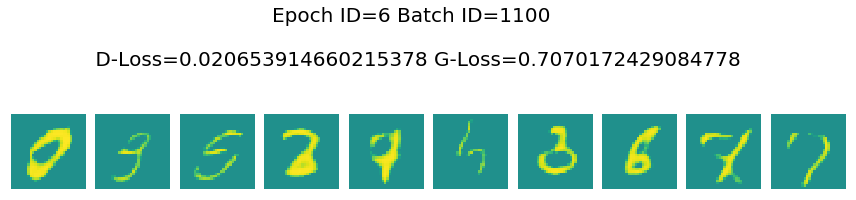

Epoch ID=6 Batch ID=1200 

 D-Loss=0.4031357765197754 G-Loss=0.3563750982284546


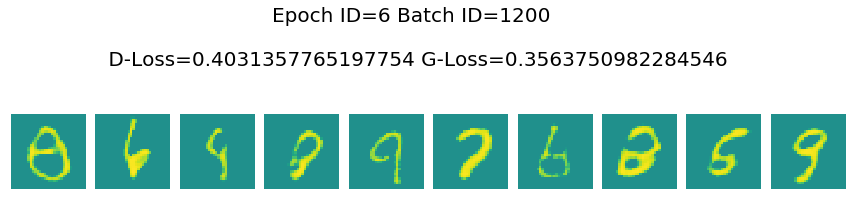

Epoch ID=6 Batch ID=1300 

 D-Loss=0.02619960345327854 G-Loss=1.2619917392730713


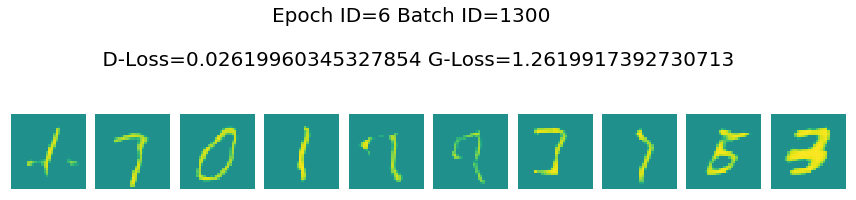

Epoch ID=6 Batch ID=1400 

 D-Loss=0.034914277493953705 G-Loss=0.9082483053207397


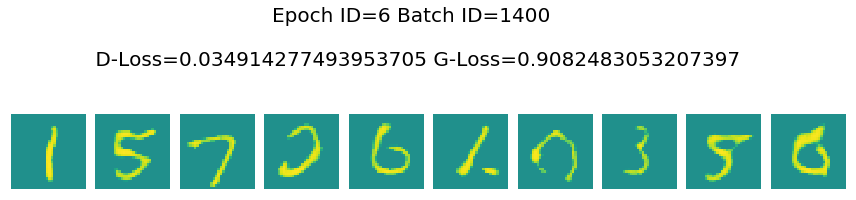

Epoch ID=6 Batch ID=1500 

 D-Loss=0.01543592382222414 G-Loss=1.0209239721298218


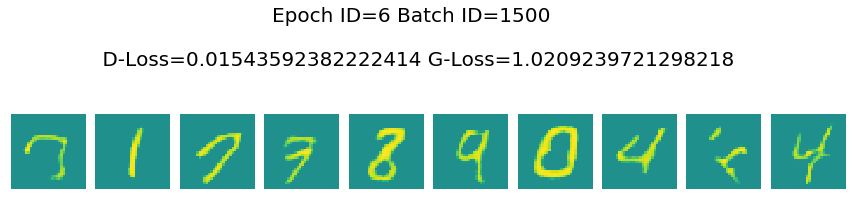

Epoch ID=6 Batch ID=1600 

 D-Loss=0.0991731658577919 G-Loss=0.8447035551071167


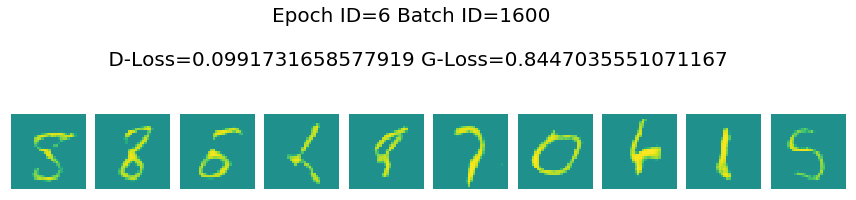

Epoch ID=6 Batch ID=1700 

 D-Loss=0.06153611093759537 G-Loss=1.100730538368225


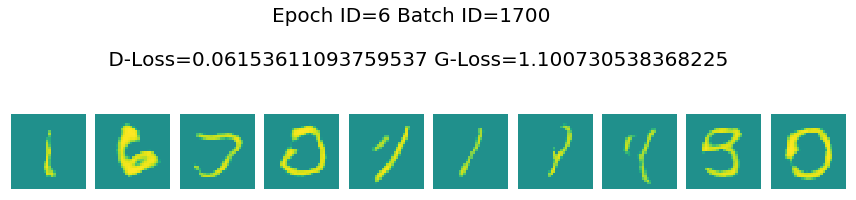

Epoch ID=6 Batch ID=1800 

 D-Loss=0.3172110319137573 G-Loss=0.40362223982810974


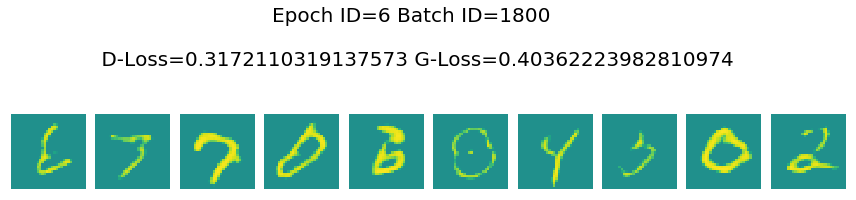

Epoch ID=7 Batch ID=0 

 D-Loss=0.07178552448749542 G-Loss=0.7619243860244751


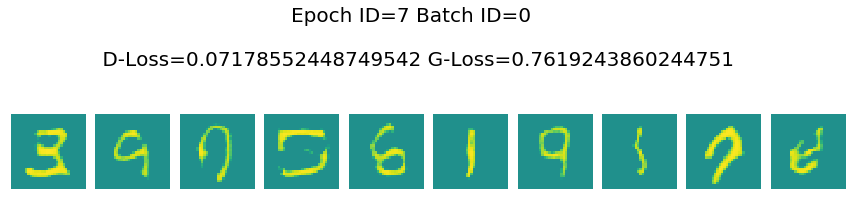

Epoch ID=7 Batch ID=100 

 D-Loss=0.043110284954309464 G-Loss=1.1264233589172363


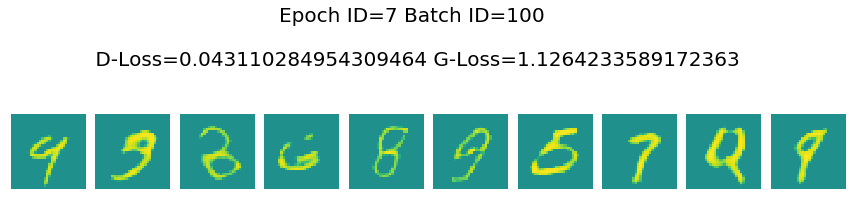

Epoch ID=7 Batch ID=200 

 D-Loss=0.0427745059132576 G-Loss=1.0174086093902588


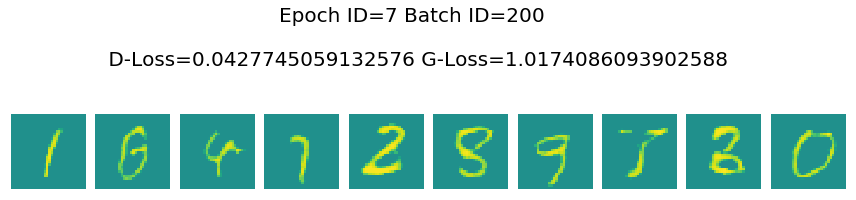

Epoch ID=7 Batch ID=300 

 D-Loss=0.030393987894058228 G-Loss=1.1953678131103516


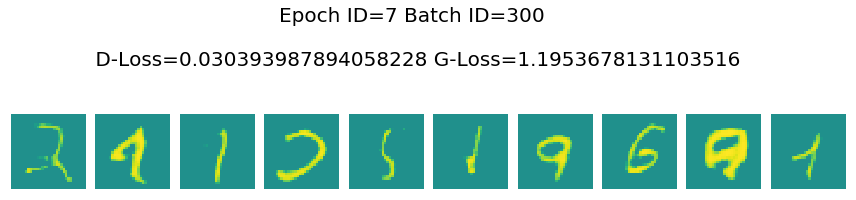

Epoch ID=7 Batch ID=400 

 D-Loss=0.013855312019586563 G-Loss=1.2754101753234863


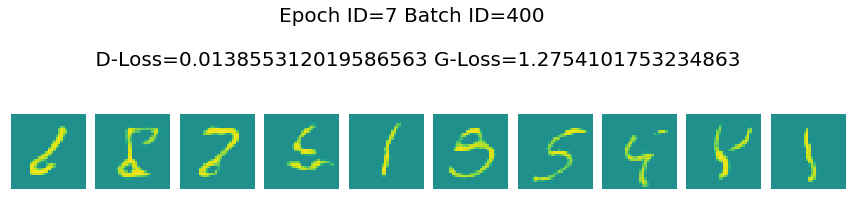

Epoch ID=7 Batch ID=500 

 D-Loss=0.02710580825805664 G-Loss=1.0495833158493042


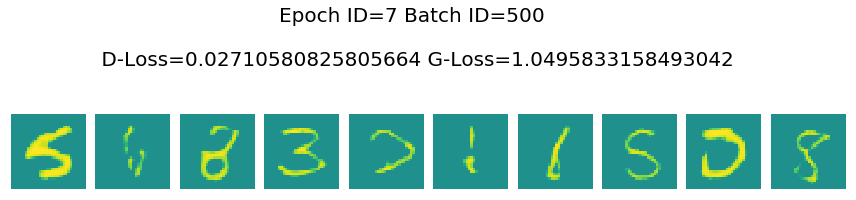

Epoch ID=7 Batch ID=600 

 D-Loss=0.02438385784626007 G-Loss=1.1158664226531982


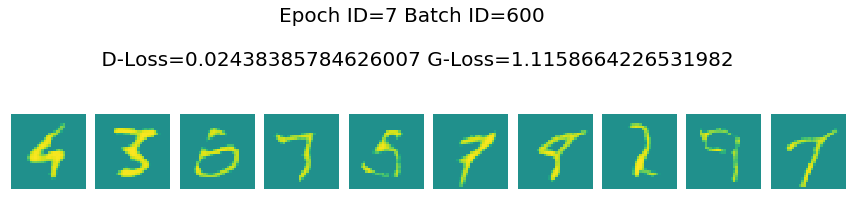

Epoch ID=7 Batch ID=700 

 D-Loss=0.057371586561203 G-Loss=0.8972680568695068


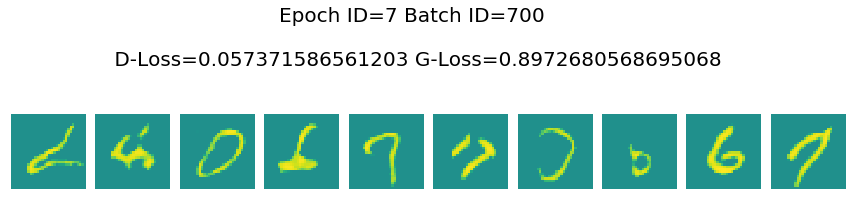

Epoch ID=7 Batch ID=800 

 D-Loss=0.032889507710933685 G-Loss=1.0718318223953247


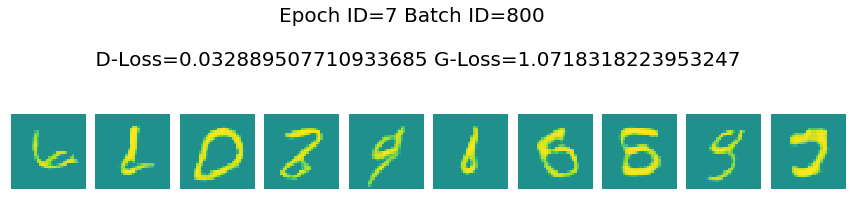

Epoch ID=7 Batch ID=900 

 D-Loss=0.050472453236579895 G-Loss=1.3396447896957397


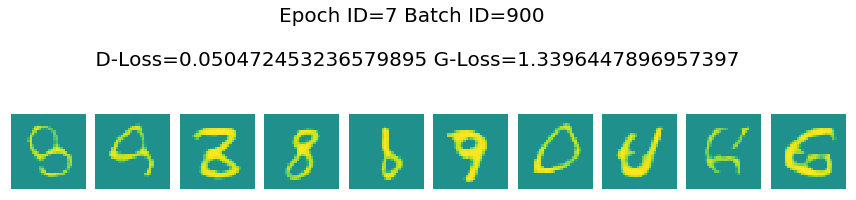

Epoch ID=7 Batch ID=1000 

 D-Loss=0.009586095809936523 G-Loss=0.8616193532943726


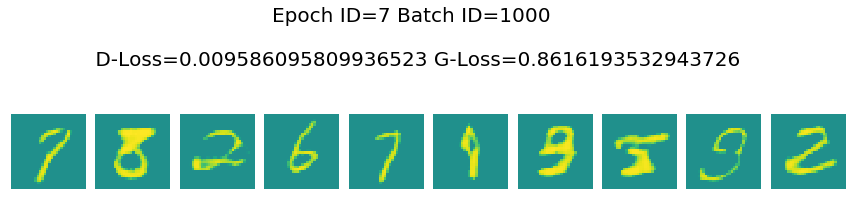

Epoch ID=7 Batch ID=1100 

 D-Loss=0.12401770800352097 G-Loss=1.2536407709121704


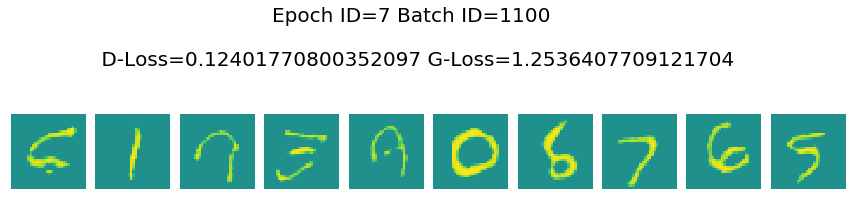

Epoch ID=7 Batch ID=1200 

 D-Loss=0.016994334757328033 G-Loss=0.9867795705795288


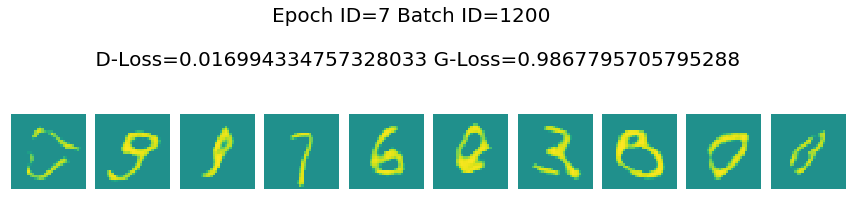

Epoch ID=7 Batch ID=1300 

 D-Loss=0.04680376872420311 G-Loss=0.7252082824707031


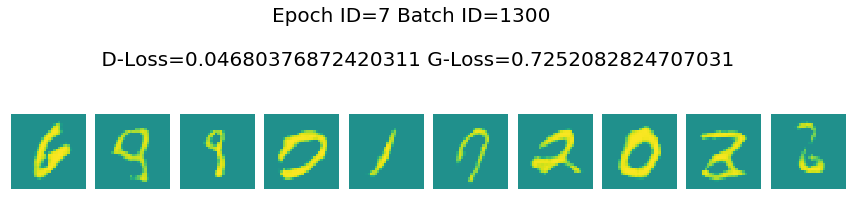

Epoch ID=7 Batch ID=1400 

 D-Loss=0.07015638053417206 G-Loss=0.9842150807380676


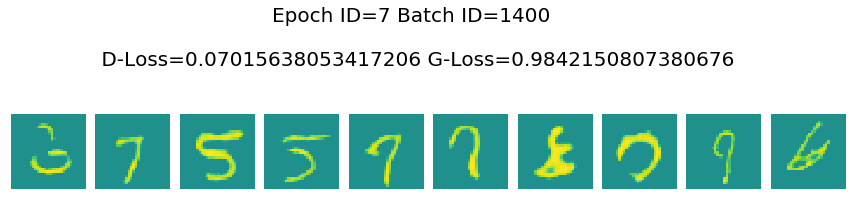

Epoch ID=7 Batch ID=1500 

 D-Loss=0.02243942953646183 G-Loss=1.1507141590118408


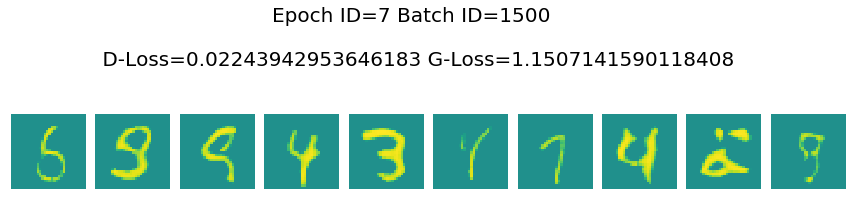

Epoch ID=7 Batch ID=1600 

 D-Loss=0.026233293116092682 G-Loss=1.2549341917037964


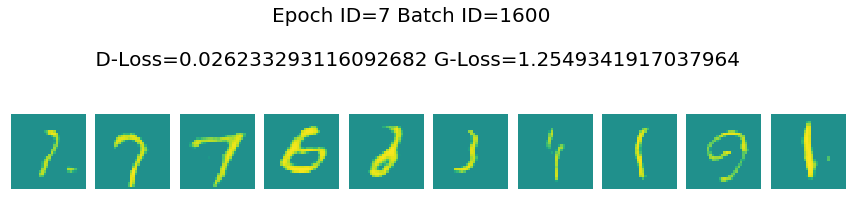

Epoch ID=7 Batch ID=1700 

 D-Loss=0.17281611263751984 G-Loss=0.6547861099243164


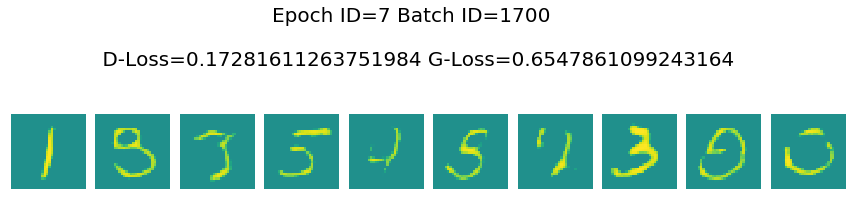

Epoch ID=7 Batch ID=1800 

 D-Loss=0.04404313862323761 G-Loss=0.8433595895767212


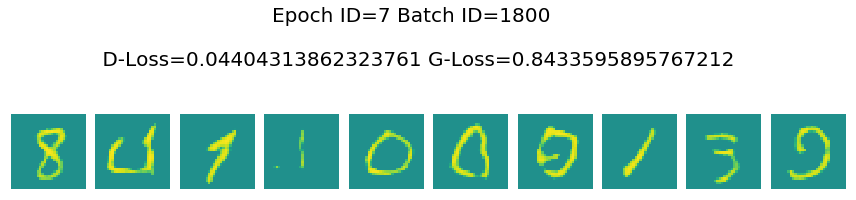

Epoch ID=8 Batch ID=0 

 D-Loss=0.0446670837700367 G-Loss=0.5091173648834229


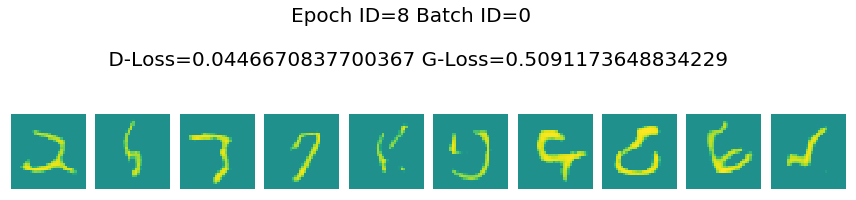

Epoch ID=8 Batch ID=100 

 D-Loss=0.055372778326272964 G-Loss=0.9569443464279175


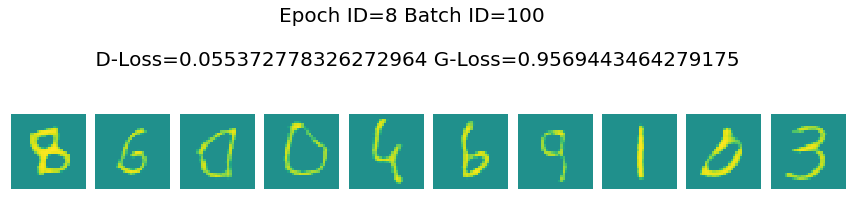

Epoch ID=8 Batch ID=200 

 D-Loss=0.04039100557565689 G-Loss=1.2446329593658447


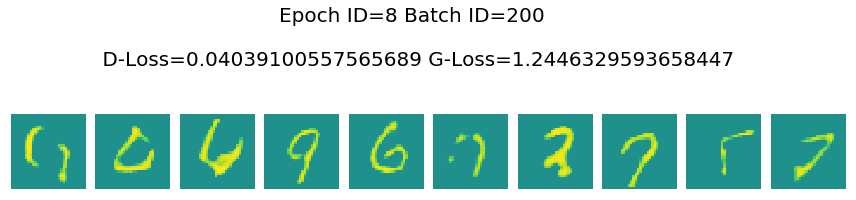

Epoch ID=8 Batch ID=300 

 D-Loss=0.03334881365299225 G-Loss=1.4547276496887207


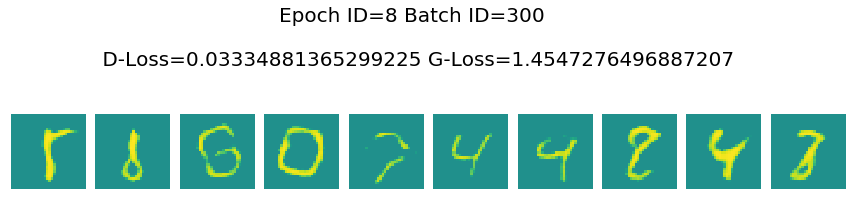

Epoch ID=8 Batch ID=400 

 D-Loss=0.05359448865056038 G-Loss=0.7741668224334717


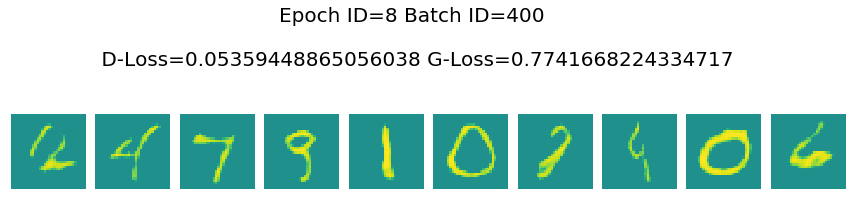

Epoch ID=8 Batch ID=500 

 D-Loss=0.010294636711478233 G-Loss=0.7558459043502808


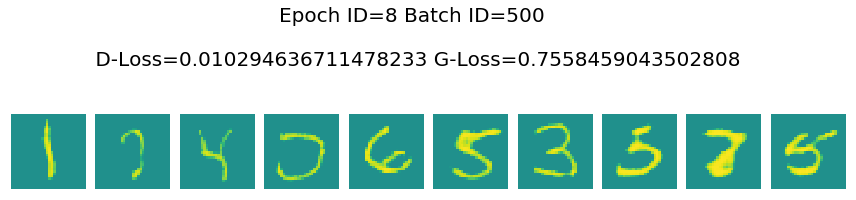

Epoch ID=8 Batch ID=600 

 D-Loss=0.055787548422813416 G-Loss=0.9195583462715149


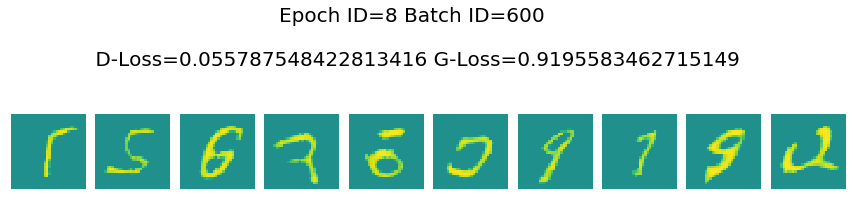

Epoch ID=8 Batch ID=700 

 D-Loss=0.018563484773039818 G-Loss=1.0548795461654663


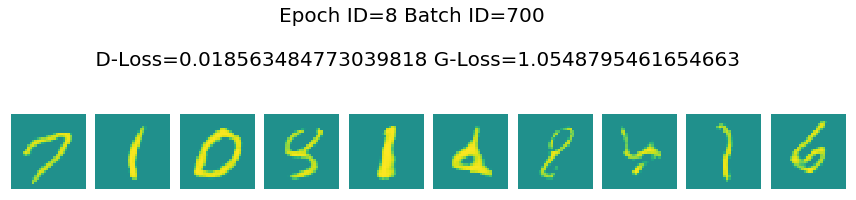

Epoch ID=8 Batch ID=800 

 D-Loss=0.024164248257875443 G-Loss=0.9280871152877808


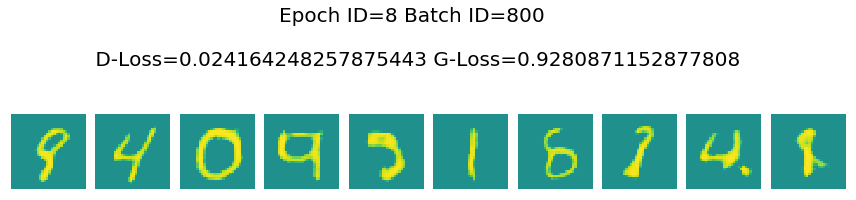

Epoch ID=8 Batch ID=900 

 D-Loss=0.017310049384832382 G-Loss=0.9540886282920837


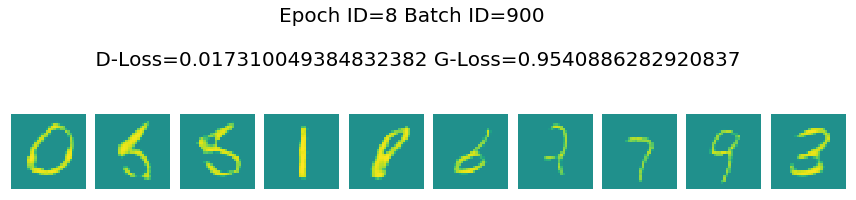

Epoch ID=8 Batch ID=1000 

 D-Loss=0.12553158402442932 G-Loss=0.3305380940437317


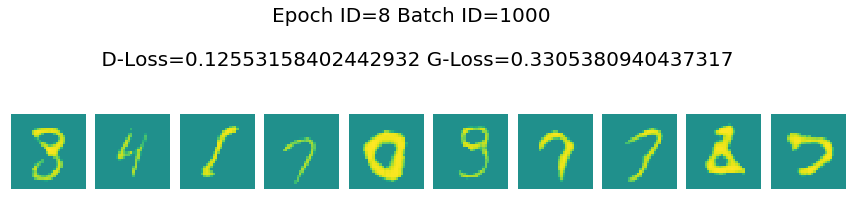

Epoch ID=8 Batch ID=1100 

 D-Loss=0.06006326526403427 G-Loss=0.7279671430587769


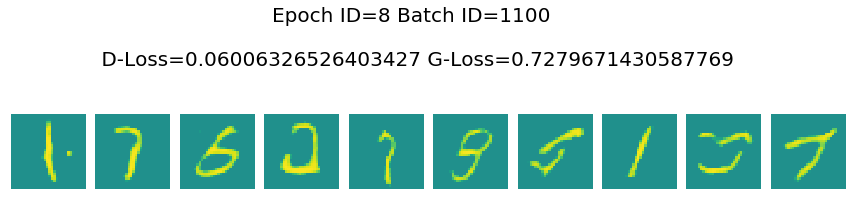

Epoch ID=8 Batch ID=1200 

 D-Loss=0.022425714880228043 G-Loss=1.4495134353637695


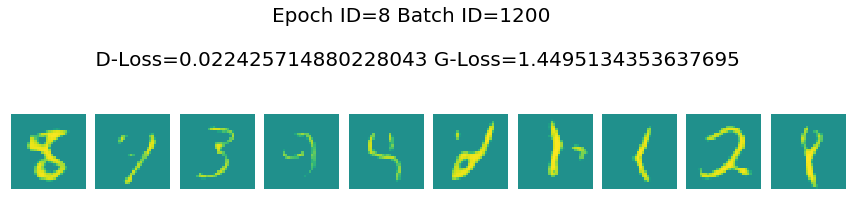

Epoch ID=8 Batch ID=1300 

 D-Loss=0.025698857381939888 G-Loss=0.8101200461387634


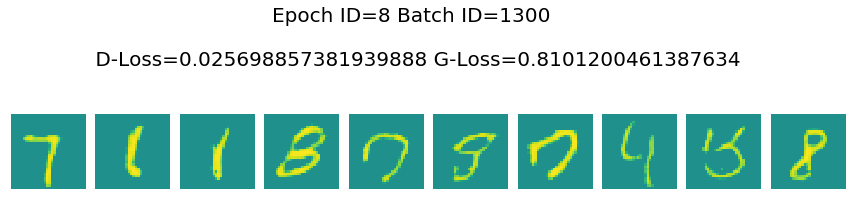

Epoch ID=8 Batch ID=1400 

 D-Loss=0.06444501876831055 G-Loss=1.4980266094207764


Epoch ID=8 Batch ID=1500 

 D-Loss=0.014880193397402763 G-Loss=1.246960163116455


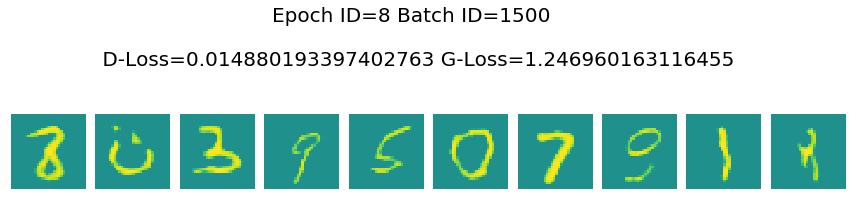

Epoch ID=8 Batch ID=1600 

 D-Loss=0.016160041093826294 G-Loss=0.9934207201004028


Epoch ID=8 Batch ID=1700 

 D-Loss=0.0457480326294899 G-Loss=1.1074824333190918


Epoch ID=8 Batch ID=1800 

 D-Loss=0.03546405956149101 G-Loss=1.086189866065979


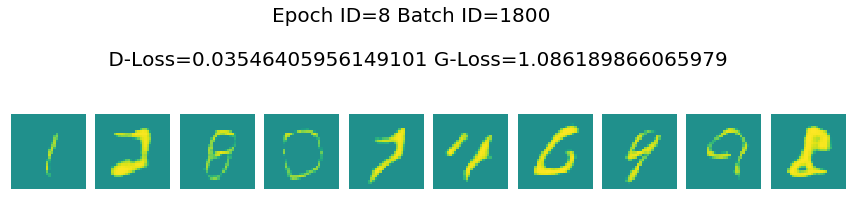

Epoch ID=9 Batch ID=0 

 D-Loss=0.21339407563209534 G-Loss=0.6788879632949829


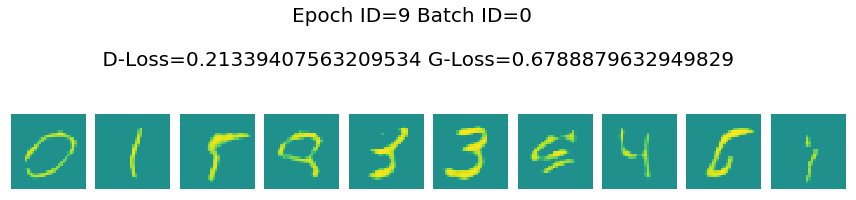

Epoch ID=9 Batch ID=100 

 D-Loss=0.059920310974121094 G-Loss=0.7558026313781738


Epoch ID=9 Batch ID=200 

 D-Loss=0.031054958701133728 G-Loss=1.1433501243591309


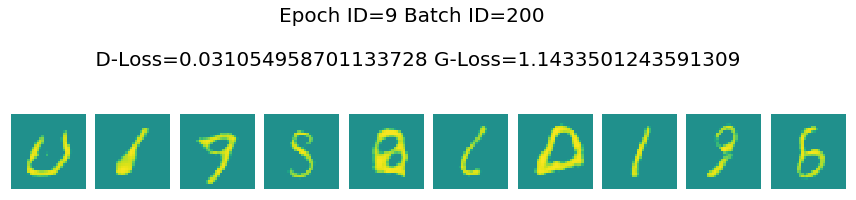

Epoch ID=9 Batch ID=300 

 D-Loss=0.03353169560432434 G-Loss=0.9590927362442017


Epoch ID=9 Batch ID=400 

 D-Loss=0.027730757370591164 G-Loss=0.7452489733695984


Epoch ID=9 Batch ID=500 

 D-Loss=0.3076443076133728 G-Loss=0.4144553542137146


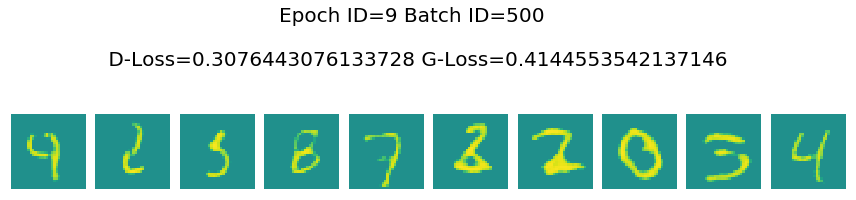

Epoch ID=9 Batch ID=600 

 D-Loss=0.025147590786218643 G-Loss=0.787614107131958


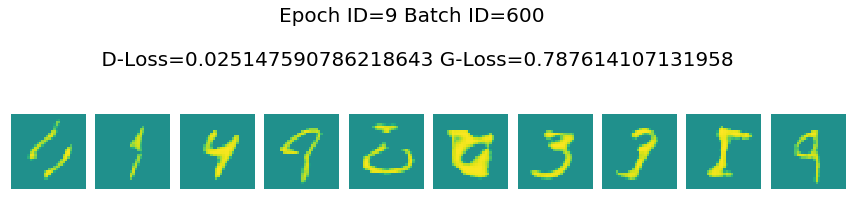

Epoch ID=9 Batch ID=700 

 D-Loss=0.04605400562286377 G-Loss=0.781470000743866


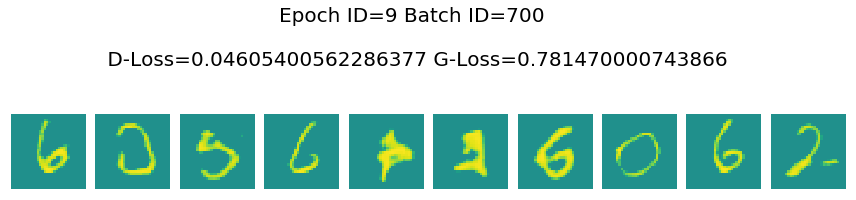

KeyboardInterrupt: 

In [9]:
losses = [[], []]
#plt.ion()
now = 0
for pass_id in range(100):
    for batch_id, (data, target) in enumerate(dataloader):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################

        optimizerD.clear_grad()
        real_img = data
        bs_size = real_img.shape[0]
        label = paddle.full((bs_size, 1, 1, 1), real_label, dtype='float32')
        real_out = netD(real_img)
        errD_real = loss(real_out, label)
        errD_real.backward()

        noise = paddle.randn([bs_size, 100, 1, 1], 'float32')
        fake_img = netG(noise)
        label = paddle.full((bs_size, 1, 1, 1), fake_label, dtype='float32')
        fake_out = netD(fake_img.detach())
        errD_fake = loss(fake_out,label)
        errD_fake.backward()
        optimizerD.step()
        optimizerD.clear_grad()

        errD = errD_real + errD_fake
        losses[0].append(errD.numpy()[0])

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        optimizerG.clear_grad()
        noise = paddle.randn([bs_size, 100, 1, 1],'float32')
        fake = netG(noise)
        label = paddle.full((bs_size, 1, 1, 1), real_label, dtype=np.float32,)
        output = netD(fake)
        errG = loss(output,label)
        errG.backward()
        optimizerG.step()
        optimizerG.clear_grad()

        losses[1].append(errG.numpy()[0])


        ############################
        # visualize
        ###########################
        if batch_id % 100 == 0:
            generated_image = netG(noise).numpy()
            imgs = []
            plt.figure(figsize=(15,15))
            try:
                for i in range(10):
                    image = generated_image[i].transpose()
                    image = np.where(image > 0, image, 0)
                    image = image.transpose((1,0,2))
                    plt.subplot(10, 10, i + 1)
                    
                    plt.imshow(image[...,0], vmin=-1, vmax=1)
                    plt.axis('off')
                    plt.xticks([])
                    plt.yticks([])
                    plt.subplots_adjust(wspace=0.1, hspace=0.1)
                msg = 'Epoch ID={0} Batch ID={1} \n\n D-Loss={2} G-Loss={3}'.format(pass_id, batch_id, errD.numpy()[0], errG.numpy()[0])
                print(msg)
                plt.suptitle(msg,fontsize=20)
                plt.draw()
                plt.savefig('{}/{:04d}_{:04d}.png'.format('work', pass_id, batch_id), bbox_inches='tight')
                plt.pause(0.01)
            except IOError:
                print(IOError)
    paddle.save(netG.state_dict(), "work/generator.params")

请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 